In [1]:
from vidHandlr import *
from waterline import *
from custom_watershed import *
from dataHandlr import *
import numpy as np
import cv2
import matplotlib.pyplot as plt
import plotly
import plotly.plotly as ply
import plotly.graph_objs as go
from alldata_20131031 import *

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
import matplotlib
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 14, # fontsize for x and y labels (was 10)
    'axes.titlesize': 20,
    'font.size': 14, # was 10
    'legend.fontsize': 10, # was 10
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'text.usetex': False,
    'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
}
matplotlib.rcParams.update(params)

In [4]:
allfrog_rev = {
'AC03_22' : False,
'AC03_20' : False,
'AC03_04' : True,
'AC01_05' : False,
'AC01_10' : False,
'AC03_15' : True, 
'AC03_06': False,
'AC01_06': False,
'AC03_14': True,
'AC01_04': False,
'AC03_21': False,
'AC03_23': False,
'AC03_18': True,
'AC03_09': True,
'AC04_03': False    
}

In [5]:
def adjust_spines(ax,spines):
	#"""From matplotlin examples"""
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward',10)) # outward by 10 points
            spine.set_smart_bounds(True)
        else:
            spine.set_color('none') # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks_position('none')
        ax.yaxis.set_ticks([])


    if 'bottom' in spines:

        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks_position('none')
        ax.xaxis.set_ticks([])	

In [6]:
import matplotlib
import matplotlib.offsetbox
from matplotlib.lines import Line2D
class AnchoredHScaleBar(matplotlib.offsetbox.AnchoredOffsetbox):
    """ size: length of bar in data units
        extent : height of bar ends in axes units """
    def __init__(self, size=1, extent = 0.03, label="", loc=2, ax=None,
                 pad=0.4, borderpad=0.5, ppad = 0, sep=2, prop=None, 
                 frameon=True, **kwargs):
        if not ax:
            ax = plt.gca()
        trans = ax.get_xaxis_transform()
        size_bar = matplotlib.offsetbox.AuxTransformBox(trans)
        line = Line2D([0,size],[0,0], **kwargs)
        vline1 = Line2D([0,0],[-extent/2.,extent/2.], **kwargs)
        vline2 = Line2D([size,size],[-extent/2.,extent/2.], **kwargs)
        size_bar.add_artist(line)
        size_bar.add_artist(vline1)
        size_bar.add_artist(vline2)
        txt = matplotlib.offsetbox.TextArea(label, minimumdescent=False)
        self.vpac = matplotlib.offsetbox.VPacker(children=[size_bar,txt],  
                                 align="center", pad=ppad, sep=sep) 
        matplotlib.offsetbox.AnchoredOffsetbox.__init__(self, loc, pad=pad, 
                 borderpad=borderpad, child=self.vpac, prop=prop, frameon=frameon)

In [7]:
def graph_all(key, time='ms', rev = False):
    data = loadSingleFrog(key)
    scale = frog_size[key]
    id_maxVel = maxVelIdx[key]

    fig, ax = plt.subplots(nrows = 4, sharex = True, figsize = (10, 16))

    unc = np.std(data['ellh'])/data['pxSVL'] #uncertainty in SVL size
    
    if time == 'ms':
        thetime = data['time']*1000
        ftt = 1000/data['fps']
    if time == 'sec':
        thetime = data['time']
        ftt = 1/data['fps']
    if time == 'frame':
        thetime = data['frameno']
        ftt = 1
    if rev:
        angrev = -1

    else:
        angrev = 1
    
    ############
    # GAIT
    ############
    
    
    if data['HL_a'] is not None:
        HL_a = [(x*ftt, y*ftt) for (x, y) in data['HL_a']]
        HL_t = [(x*ftt, y*ftt) for (x, y) in data['HL_t']]
        FL_t = [(x*ftt, y*ftt) for (x, y) in data['FL_t']]
        FL_a = [(x*ftt, y*ftt) for (x, y) in data['FL_a']]
        
        for t_val in HL_t:
            for a_val in HL_a:
                if np.abs(a_val[0] - (t_val[0] + t_val[1])) < 25*ftt:
                    #print(t_val, a_val)
                    start = (t_val[0] + t_val[1])
                    end = a_val[0] - start
                    hatch_bar = ax[3].broken_barh([(start, end)], (1, 2), facecolors='gray', hatch='////')
        
        
        black_bar = ax[3].broken_barh(HL_a, (1, 2), facecolors='black')
        gray_bar = ax[3].broken_barh(HL_t, (1, 2), facecolors='gray')
        ax[3].broken_barh(FL_a, (3.5, 2), facecolors='black')
        ax[3].broken_barh(FL_t, (3.5, 2), facecolors='gray')
        for val in data['HL_a']:
            cx = val[0] + val[1]/2
            cy = 1 + 2/2
            cx = cx*ftt
    
            ax[3].annotate('A', (cx, cy), color='w', weight='bold', fontsize=12, ha='center', va='center')

        for val in data['HL_t']:
            cx = val[0] + val[1]/2
            cy = 1 + 2/2
            cx = cx*ftt
    
            ax[3].annotate('T', (cx, cy), color='w', weight='bold', fontsize=12, ha='center', va='center')
    
        for val in data['FL_t']:
            cx = val[0] + val[1]/2
            cy = 3.5 + 2/2
            cx = cx*ftt
    
            ax[3].annotate('T', (cx, cy), color='w', weight='bold', fontsize=12, ha='center', va='center')
    
        for val in data['FL_a']:
            cx = val[0] + val[1]/2
            cy = 3.5 + 2/2
            cx = cx*ftt
    
            ax[3].annotate('A', (cx, cy), color='w', weight='bold', fontsize=12, ha='center', va='center')
            
        ax[3].set_yticks([2, 4.5])
        ax[3].set_yticklabels(['HL', 'FL'])
        ax[3].set_ylabel('Gait', rotation=0, va='center', ha='right')
        ax[3].legend([black_bar, gray_bar, hatch_bar], ['Away', 'Towards', 'Transition'], fontsize=12, loc=4)
        
    ########
    #  X Position
    ########
        
    if rev:
        mntx = (np.max(data['mntx']) - data['mntx'])
    
    else:
        mntx = data['mntx'] - np.min(data['mntx'])
    ax[0].plot(thetime, mntx/data['pxSVL'], 'k.', label='raw data')
    #ax[0].scatter(thetime, mntx/data['pxSVL'], c=thetime, label='raw data', cmap='gnuplot')
    ax[0].fill_between(thetime, mntx/data['pxSVL'] - unc, mntx/data['pxSVL'] + unc, facecolor='gray', interpolate ='True')

    s_mntx = get_smooth_data(mntx, data['fps'])
    ax[0].plot(thetime, s_mntx/data['pxSVL'], 'r-', label='smoothed data')
    

    ax[0].set_ylabel('Horizontal\nposition\n(SVL)', rotation=0, ha='right', va='center')

    ax[0].legend(fontsize=12)

    axt = ax[0].twinx()
    mn, mx = ax[0].get_ylim()
    axt.set_ylim(mn*scale, mx*scale)
    axt.set_ylabel('(cm)', rotation=0, ha='left', va='center')

    #######################
    #  Y POSITION
    #######################
    
    ax[1].plot(thetime, data['mnty']/data['pxSVL'], 'k.', label='orig')

    s_mnty = get_smooth_data(data['mnty'], data['fps'])
    ax[1].plot(thetime, s_mnty/data['pxSVL'], 'r-', label='smooth')
    ax[1].fill_between(thetime,  data['mnty']/data['pxSVL'] - unc, data['mnty']/data['pxSVL'] + unc, facecolor='gray', interpolate ='True')


    ax[1].set_ylabel('Vertical\nposition\n(SVL)', rotation=0, va='center', ha='right')
    ax[1].axhline(0, color='c', label='water line')

    #plt.legend()

    axt = ax[1].twinx()
    mn, mx = ax[1].get_ylim()
    axt.set_ylim(mn*scale, mx*scale)
    axt.set_ylabel('(cm)', rotation=0, ha='left', va='center')

    #############################
    # BODY ANGLE
    ###########################

    ax[2].plot(thetime, angrev*data['mnta'], 'k.', label='orig')

    s_mnta = get_smooth_data(data['mnta'], data['fps'])             
                 
    ax[2].plot(thetime, angrev*s_mnta, 'r-', label='smooth')
    
    en = int(len(thetime)/30)
    
    ax[2].quiver(thetime[::en],np.ones(thetime.shape)[::en] *(np.min(angrev*data['mnta'] - 15)), np.cos(np.deg2rad(angrev*s_mnta))[::en],np.sin(np.deg2rad(angrev*s_mnta))[::en],
         headwidth=1, headlength=3)
    
    
    
    
    
    ax[2].set_ylabel('Body\nAngle\n(deg)', rotation=0, va='center', ha='right')
    
    #for idx, tax in enumerate(ax):             
    #    for o in np.array(thetime)[data['watercontactIdx']]:
    #        if idx == 0:
    #            y_max = 1
    #            y_min = 0
    #        else:
    #            y_min = 0
    #            y_max = 1.2
    #        tax.axvline(x = o, color='k', ymin = y_min, ymax = y_max, zorder=0, clip_on=False)
    ax[3].set_xlabel('Time (%s)' %time)
    
    water = [0] + list(data['watercontactIdx'][0]) + [len(data['frameno']) - 1]
    #print(s_mnty[water])
    test = [(water[i], water[i+1]) for i in range(len(water) - 1) if s_mnty[int(np.mean([water[i], water[i+1]]))] < 0]
    
    for idx, tax in enumerate(ax):             
        for o in test:
            if idx == 0:
                y_max = 1
                y_min = 0
            else:
                y_min = 0
                y_max = 1.2
            if o[0] == 0:
                start = np.array(thetime)[o[0]] - 10*ftt
            else:
                start = np.array(thetime)[o[0]] 
            if o[1] == len(s_mnty) - 1:
                end = np.array(thetime)[o[1]] + 10 *ftt
            else:
                end = np.array(thetime)[o[1]]
            tax.axvspan(start, end, ymin = y_min, ymax = y_max, facecolor='k', alpha = .2, zorder = 0, clip_on=False)
            
    
    ax[0].set_title(key)
                 
        
    #set bounds
    xmin = np.array(thetime)[water[0]] - 10*ftt
    xmax = np.array(thetime)[water[-1]] + 10*ftt
    ax[3].set_xbound([xmin, xmax])
    
    
    
    #remove xaxis
    #for tax in ax:
        #print(idx)
    #    for loc, spine in tax.spines.items():
    #        if loc in ['bottom', 'top']:
    #            spine.set_color('none') # don't draw spine

    
    #ob = AnchoredHScaleBar(size=100, label="100 ms", loc=4, frameon=False,
    #                   pad=0.6,sep=4,color="k")
    #ax[3].add_artist(ob)
    #ax[3].axvline(data['time'][151]*1000, color='c', label='Max vertical velocity')
    return ax, fig
       
    #adjust_spines(ax[2], ['left', 'right'])
    #adjust_spines(ax[3], ['left', 'right', 'bottom'])


In [8]:
def graph_all_vel(key, time='ms', rev = False):
    data = loadSingleFrog(key)
    scale = frog_size[key]
    id_maxVel = maxVelIdx[key]

    fig, ax = plt.subplots(nrows = 6, sharex = True, figsize = (10, 16))

    unc = np.std(data['ellh'])/data['pxSVL'] #uncertainty in SVL size
    
    if time == 'ms':
        thetime = data['time']*1000
        ftt = 1000/data['fps']
    if time == 'sec':
        thetime = data['time']
        ftt = 1/data['fps']
    if time == 'frame':
        thetime = data['frameno']
        ftt = 1
    if rev:
        angrev = -1

    else:
        angrev = 1
    
    ####
    # Gait Diagram
    ####
    if data['HL_a'] is not None:
        HL_a = [(x*ftt, y*ftt) for (x, y) in data['HL_a']]
        HL_t = [(x*ftt, y*ftt) for (x, y) in data['HL_t']]
        FL_t = [(x*ftt, y*ftt) for (x, y) in data['FL_t']]
        FL_a = [(x*ftt, y*ftt) for (x, y) in data['FL_a']]
        
        for t_val in HL_t:
            for a_val in HL_a:
                if np.abs(a_val[0] - (t_val[0] + t_val[1])) < 25*ftt:
                    #print(t_val, a_val)
                    start = (t_val[0] + t_val[1])
                    end = a_val[0] - start
                    ax[5].broken_barh([(start, end)], (1, 2), facecolors='gray', hatch='////')
        
        
        ax[5].broken_barh(HL_a, (1, 2), facecolors='black')
        ax[5].broken_barh(HL_t, (1, 2), facecolors='gray')
        ax[5].broken_barh(FL_a, (3.5, 2), facecolors='black')
        ax[5].broken_barh(FL_t, (3.5, 2), facecolors='gray')
        for val in data['HL_a']:
            cx = val[0] + val[1]/2
            cy = 1 + 2/2
            cx = cx*ftt
    
            #ax[5].annotate('AWAY', (cx, cy), color='w', weight='bold', fontsize=8, ha='center', va='center')

        for val in data['HL_t']:
            cx = val[0] + val[1]/2
            cy = 1 + 2/2
            cx = cx*ftt
    
            #ax[5].annotate('TOWARD', (cx, cy), color='w', weight='bold', fontsize=8, ha='center', va='center')
    
        for val in data['FL_t']:
            cx = val[0] + val[1]/2
            cy = 3.5 + 2/2
            cx = cx*ftt
    
            #ax[5].annotate('TOW', (cx, cy), color='w', weight='bold', fontsize=8, ha='center', va='center')
    
        for val in data['FL_a']:
            cx = val[0] + val[1]/2
            cy = 3.5 + 2/2
            cx = cx*ftt
    
            #ax[5].annotate('AWA', (cx, cy), color='w', weight='bold', fontsize=8, ha='center', va='center')
            
        ax[5].set_yticks([2, 4.5])
        ax[5].set_yticklabels(['HL', 'FL'])
        ax[5].set_ylabel('Gait', rotation=0, va='center', ha='right')
    if rev:
        mntx = (np.max(data['mntx']) - data['mntx'])
    
    else:
        mntx = data['mntx'] - np.min(data['mntx'])
    
    ####
    # Horizontal position
    ####
    ax[0].plot(thetime, mntx/data['pxSVL'], 'k.', label='orig')
    ax[0].fill_between(thetime, mntx/data['pxSVL'] - unc, mntx/data['pxSVL'] + unc, facecolor='gray', interpolate ='True')

    s_mntx = get_smooth_data(mntx, data['fps'])
    ax[0].plot(thetime, s_mntx/data['pxSVL'], 'r-', label='smooth')
    

    ax[0].set_ylabel('Horizontal\nposition\n(SVL)', rotation=0, ha='right', va='center')

    ax[0].legend()

    axt = ax[0].twinx()
    mn, mx = ax[0].get_ylim()
    axt.set_ylim(mn*scale, mx*scale)
    axt.set_ylabel('(cm)', rotation=0, ha='left', va='center')


    ####
    # Vertical Position
    ####

    ax[1].plot(thetime, data['mnty']/data['pxSVL'], 'k.', label='orig')

    s_mnty = get_smooth_data(data['mnty'], data['fps'])
    ax[1].plot(thetime, s_mnty/data['pxSVL'], 'r-', label='smooth')
    ax[1].fill_between(thetime,  data['mnty']/data['pxSVL'] - unc, data['mnty']/data['pxSVL'] + unc, facecolor='gray', interpolate ='True')


    ax[1].set_ylabel('Vertical\nposition\n(SVL)', rotation=0, va='center', ha='right')
    ax[1].axhline(0, color='c', label='water line')

    #plt.legend()

    axt = ax[1].twinx()
    mn, mx = ax[1].get_ylim()
    axt.set_ylim(mn*scale, mx*scale)
    axt.set_ylabel('(cm)', rotation=0, ha='left', va='center')


    
    ####
    # Horizontal Velocity
    ####
    v_smntx=np.gradient(s_mntx, data['time'])
    ax[2].plot(thetime, v_smntx/data['pxSVL'], 'k.', label='orig')
    ax[2].fill_between(thetime, v_smntx/data['pxSVL'] - unc, v_smntx/data['pxSVL'] + unc, facecolor='gray', interpolate ='True')


    

    ax[2].set_ylabel('Horizontal\nvelocity\n(SVL/sec)',rotation=0, ha='right', va='center')

    

    axt = ax[2].twinx()
    mn, mx = ax[2].get_ylim()
    axt.set_ylim(mn*scale, mx*scale)
    axt.set_ylabel('(cm/sec)', rotation=0, ha='left', va='center')

    
    
    
    
    ####
    # Vertical Velocity
    ####
    v_smnty= np.gradient(s_mnty, data['time'])
    
    ax[3].plot(thetime, v_smnty/data['pxSVL'], 'k.', label='orig')
    ax[3].fill_between(thetime, v_smnty/data['pxSVL'] - unc, v_smnty/data['pxSVL'] + unc, facecolor='r', interpolate ='True')


    

    ax[3].set_ylabel('Vertical\nvelocity\n(SVL/sec)',rotation=0, ha='right', va='center')

    

    axt = ax[3].twinx()
    mn, mx = ax[3].get_ylim()
    axt.set_ylim(mn*scale, mx*scale)
    axt.set_ylabel('(cm/sec)', rotation=0, ha='left', va='center')

    

    ####
    # Body Angle
    ####
    
    ax[4].plot(thetime, angrev*data['mnta'], 'k.', label='orig')

    s_mnta = get_smooth_data(data['mnta'], data['fps'])             
                 
    ax[4].plot(thetime, angrev*s_mnta, 'r-', label='smooth')
    
    everynth = int(len(thetime)/35)
    
    ax[4].quiver(thetime[::everynth],np.ones(thetime.shape)[::everynth] *(np.min(angrev*data['mnta'] - 15)), np.cos(np.deg2rad(angrev*s_mnta))[::everynth],np.sin(np.deg2rad(angrev*s_mnta))[::everynth],
         headwidth=1, headlength=3)
    
    
    
    
    
    ax[4].set_ylabel('Body\nAngle\n(deg)', rotation=0, va='center', ha='right')
    

   
    
    water = [0] + list(data['watercontactIdx'][0]) + [len(data['frameno']) - 1]
    #print(s_mnty[water])
    test = [(water[i], water[i+1]) for i in range(len(water) - 1) if s_mnty[int(np.mean([water[i], water[i+1]]))] < 0]
    
    for idx, tax in enumerate(ax):             
        for o in test:
            if idx == 0:
                y_max = 1
                y_min = 0
            else:
                y_min = 0
                y_max = 1.2
            if o[0] == 0:
                start = np.array(thetime)[o[0]] - 10*ftt
            else:
                start = np.array(thetime)[o[0]] 
            if o[1] == len(s_mnty) - 1:
                end = np.array(thetime)[o[1]] + 10 *ftt
            else:
                end = np.array(thetime)[o[1]]
            tax.axvspan(start, end, ymin = y_min, ymax = y_max, facecolor='k', alpha = .2, zorder = 0, clip_on=False)
            
    
    ax[0].set_title(key)
    ax[5].set_xlabel('Time (%s)' %time)
                 
        
    #set bounds
    xmin = np.array(thetime)[water[0]] - 10*ftt
    xmax = np.array(thetime)[water[-1]] + 10*ftt
    ax[5].set_xbound([xmin, xmax])
    
    
    
    #remove xaxis
    #for tax in ax:
        #print(idx)
    #    for loc, spine in tax.spines.items():
    #        if loc in ['bottom', 'top']:
    #            spine.set_color('none') # don't draw spine

    
    #ob = AnchoredHScaleBar(size=100, label="100 ms", loc=4, frameon=False,
    #                   pad=0.6,sep=4,color="k")
    #ax[3].add_artist(ob)
    #ax[3].axvline(data['time'][151]*1000, color='c', label='Max vertical velocity')
    return ax, fig
       
    #adjust_spines(ax[2], ['left', 'right'])
    #adjust_spines(ax[3], ['left', 'right', 'bottom'])

In [18]:
def graph_vel(key, time='ms', rev = False):
    data = loadSingleFrogwVideo(key)
    scale = frog_size[key]
    id_maxVel = maxVelIdx[key]

    fig, ax = plt.subplots(nrows = 2, sharex = True, figsize = (8, 8))

    unc = np.std(data['ellh'])
    
    perunc = unc/np.mean(data['ellh'])
    print(perunc)
    
    
    if time == 'ms':
        thetime = data['time']*1000
        ftt = 1000/data['fps']
    if time == 'sec':
        thetime = data['time']
        ftt = 1/data['fps']
    if time == 'frame':
        thetime = data['frameno']
        ftt = 1
    if rev:
        angrev = -1

    else:
        angrev = 1
    
    
    ###POSITION INFO
    if rev:
        mntx = (np.max(data['mntx']) - data['mntx'])
    
    else:
        mntx = data['mntx'] - np.min(data['mntx'])
    s_mntx = get_smooth_data(mntx, data['fps'])
    s_mnty = get_smooth_data(data['mnty'], data['fps'])
    
    ####
    # Horizontal Velocity
    ####
    v_smntx=np.gradient(s_mntx, data['time'])
    ax[0].plot(thetime, v_smntx/data['pxSVL'], 'k.', label='orig')
    

    test= 2* perunc**2*data['fps']**2
    test = np.sqrt(test)
    
    
    #ax[0].fill_between(thetime, v_smntx/data['pxSVL']*(1 - perunc), v_smntx/data['pxSVL']*(1 + perunc), facecolor='gray', interpolate ='True')
    ax[0].fill_between(thetime, v_smntx/data['pxSVL']- test, v_smntx/data['pxSVL']+test, facecolor='gray', interpolate ='True')

    

    ax[0].set_ylabel('Horizontal\nvelocity\n(SVL/sec)',rotation=0, ha='right', va='center')

    

    axt = ax[0].twinx()
    mn, mx = ax[0].get_ylim()
    axt.set_ylim(mn*scale, mx*scale)
    axt.set_ylabel('(cm/sec)', rotation=0, ha='left', va='center')

    
    
    
    
    ####
    # Vertical Velocity
    ####
    v_smnty= np.gradient(s_mnty, data['time'])
    
    a_smnty = np.gradient(v_smnty/data['pxSVL'], data['time'])
    
    #test = (perunc)**2*a_smnty**2
    #test =  np.sqrt(test)
    
    
    ax[1].plot(thetime, v_smnty/data['pxSVL'], 'k.', label='orig')
    
    
    #ax[1].fill_between(thetime, v_smnty/data['pxSVL']*(1 -  perunc), v_smnty/data['pxSVL']*(1 + perunc), facecolor='gray', interpolate ='True')

    ax[1].fill_between(thetime, v_smnty/data['pxSVL'] + test, v_smnty/data['pxSVL'] - test, facecolor='gray', interpolate ='True')
    

    ax[1].set_ylabel('Vertical\nvelocity\n(SVL/sec)',rotation=0, ha='right', va='center')

    

    axt = ax[1].twinx()
    mn, mx = ax[1].get_ylim()
    axt.set_ylim(mn*scale, mx*scale)
    axt.set_ylabel('(cm/sec)', rotation=0, ha='left', va='center')

    


   
    
    water = [0] + list(data['watercontactIdx'][0]) + [len(data['frameno']) - 1]
    #print(s_mnty[water])
    test = [(water[i], water[i+1]) for i in range(len(water) - 1) if s_mnty[int(np.mean([water[i], water[i+1]]))] < 0]
    
    for idx, tax in enumerate(ax):             
        for o in test:
            if idx == 0:
                y_max = 1
                y_min = 0
            else:
                y_min = 0
                y_max = 1.2
            if o[0] == 0:
                start = np.array(thetime)[o[0]] - 10*ftt
            else:
                start = np.array(thetime)[o[0]] 
            if o[1] == len(s_mnty) - 1:
                end = np.array(thetime)[o[1]] + 10 *ftt
            else:
                end = np.array(thetime)[o[1]]
            tax.axvspan(start, end, ymin = y_min, ymax = y_max, facecolor='k', alpha = .2, zorder = 0, clip_on=False)
            
    
    ax[0].set_title(key)
    ax[1].set_xlabel('Time (%s)' %time)
                 
        
    #set bounds
    xmin = np.array(thetime)[water[0]] - 10*ftt
    xmax = np.array(thetime)[water[-1]] + 10*ftt
    ax[1].set_xbound([xmin, xmax])
    
    
    
    #remove xaxis
    #for tax in ax:
        #print(idx)
    #    for loc, spine in tax.spines.items():
    #        if loc in ['bottom', 'top']:
    #            spine.set_color('none') # don't draw spine

    
    #ob = AnchoredHScaleBar(size=100, label="100 ms", loc=4, frameon=False,
    #                   pad=0.6,sep=4,color="k")
    #ax[3].add_artist(ob)
    #ax[3].axvline(data['time'][151]*1000, color='c', label='Max vertical velocity')
    return ax, fig
       
    #adjust_spines(ax[2], ['left', 'right'])
    #adjust_spines(ax[3], ['left', 'right', 'bottom'])

In [10]:
def graph_xy(key, time='ms', rev = False):
    data = loadSingleFrog(key)
    scale = frog_size[key]
    id_maxVel = maxVelIdx[key]

    fig, ax = plt.subplots(nrows = 1, sharex = True, figsize = (8, 4))

    unc = np.std(data['ellh'])/data['pxSVL'] #uncertainty in SVL size
    
    if time == 'ms':
        thetime = data['time']*1000
        ftt = 1000/data['fps']
    if time == 'sec':
        thetime = data['time']
        ftt = 1/data['fps']
    if time == 'frame':
        thetime = data['frameno']
        ftt = 1
    if rev:
        angrev = -1

    else:
        angrev = 1
    
    
    if rev:
        mntx = (np.max(data['mntx']) - data['mntx'])
    
    else:
        mntx = data['mntx'] - np.min(data['mntx'])
    
    ####
    # Graphing x v  y
    ####
    s_mntx = get_smooth_data(mntx, data['fps'])
    s_mnty = get_smooth_data(data['mnty'], data['fps'])
    
    ax.plot((s_mntx/data['pxSVL']*scale)[::2], (s_mnty/data['pxSVL']*scale)[::2], 'k.')
    ax.fill_between(mntx/data['pxSVL']*scale, data['mnty']/data['pxSVL']*scale - unc*scale, data['mnty']/data['pxSVL']*scale + unc*scale, facecolor='gray', interpolate ='True')

    #ax.plot(s_mntx/data['pxSVL'], s_mnty/data['pxSVL'], 'r-', label='smooth')
    

    ax.set_xlabel('Horizontal Position (cm)')
    ax.set_ylabel('Vertical\nposition\n(cm)', rotation=0, ha='right', va='center')
    ax.axhline(0, color='c', label='water line')

    #plt.legend()

    return ax, fig



In [11]:
def graph_xy2(key, time='ms', rev = False):
    data = loadSingleFrog(key)
    scale = frog_size[key]
    id_maxVel = maxVelIdx[key]

    fig, ax = plt.subplots(nrows = 1, sharex = True, figsize = (8, 4))

    unc = np.std(data['ellh'])/data['pxSVL'] #uncertainty in SVL size
    
    if time == 'ms':
        thetime = data['time']*1000
        ftt = 1000/data['fps']
    if time == 'sec':
        thetime = data['time']
        ftt = 1/data['fps']
    if time == 'frame':
        thetime = data['frameno']
        ftt = 1
    if rev:
        angrev = -1

    else:
        angrev = 1
    
    
    if rev:
        mntx = (np.max(data['mntx']) - data['mntx'])
    
    else:
        mntx = data['mntx'] - np.min(data['mntx'])
    
    ####
    # Graphing x v  y
    ####
    s_mntx = get_smooth_data(mntx, data['fps'])
    s_mnty = get_smooth_data(data['mnty'], data['fps'])
    
    
    ax.fill_between(mntx/data['pxSVL']*scale, data['mnty']/data['pxSVL']*scale - unc*scale, data['mnty']/data['pxSVL']*scale + unc*scale, facecolor='gray', interpolate ='True')
    sc = ax.scatter((s_mntx/data['pxSVL']*scale)[::2], (s_mnty/data['pxSVL']*scale)[::2], c=thetime[::2], cmap='gnuplot', marker='.')
    cbar = plt.colorbar(sc, ax=ax)
    cbar.ax.set_title('Time (%s)'%time, fontsize=12)
    #ax.plot(s_mntx/data['pxSVL'], s_mnty/data['pxSVL'], 'r-', label='smooth')
    

    ax.set_xlabel('Horizontal Position (cm)')
    ax.set_ylabel('Vertical\nposition\n(cm)', rotation=0, ha='right', va='center')
    ax.axhline(0, color='c', label='water line')

    #plt.legend()
    return ax, fig



(<matplotlib.axes._subplots.AxesSubplot at 0x7f13a4e6d160>,
 <Figure size 576x288 with 2 Axes>)

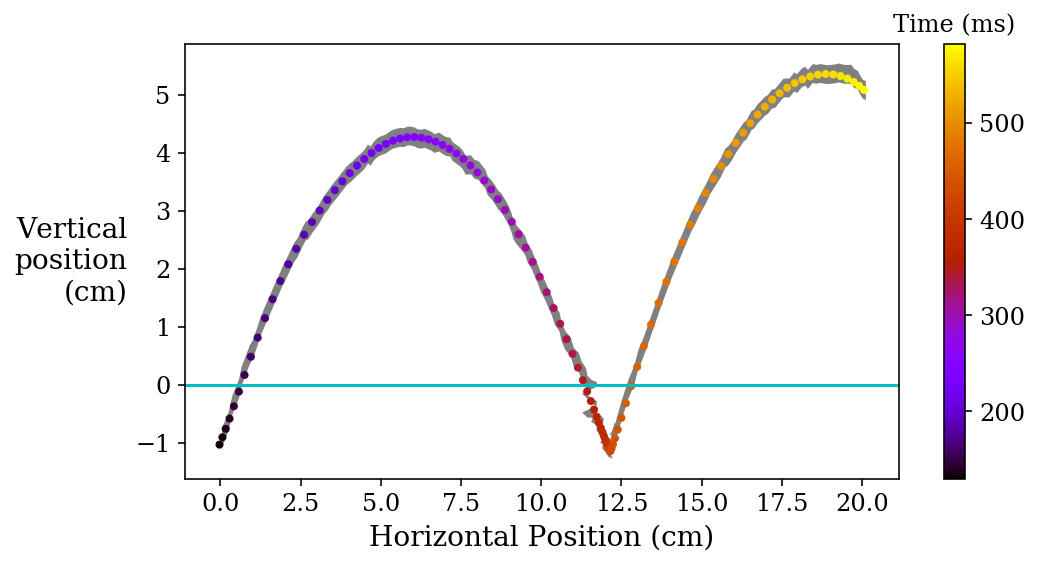

In [12]:
graph_xy2('AC01_05')

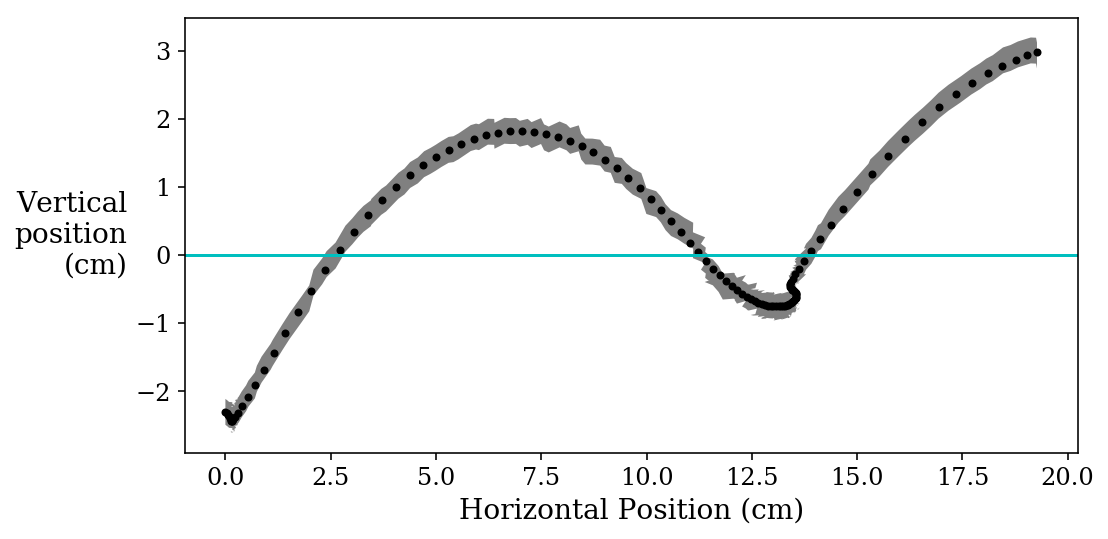

In [12]:
ax, fig = graph_xy('AC0_203')

0.08165589940917072


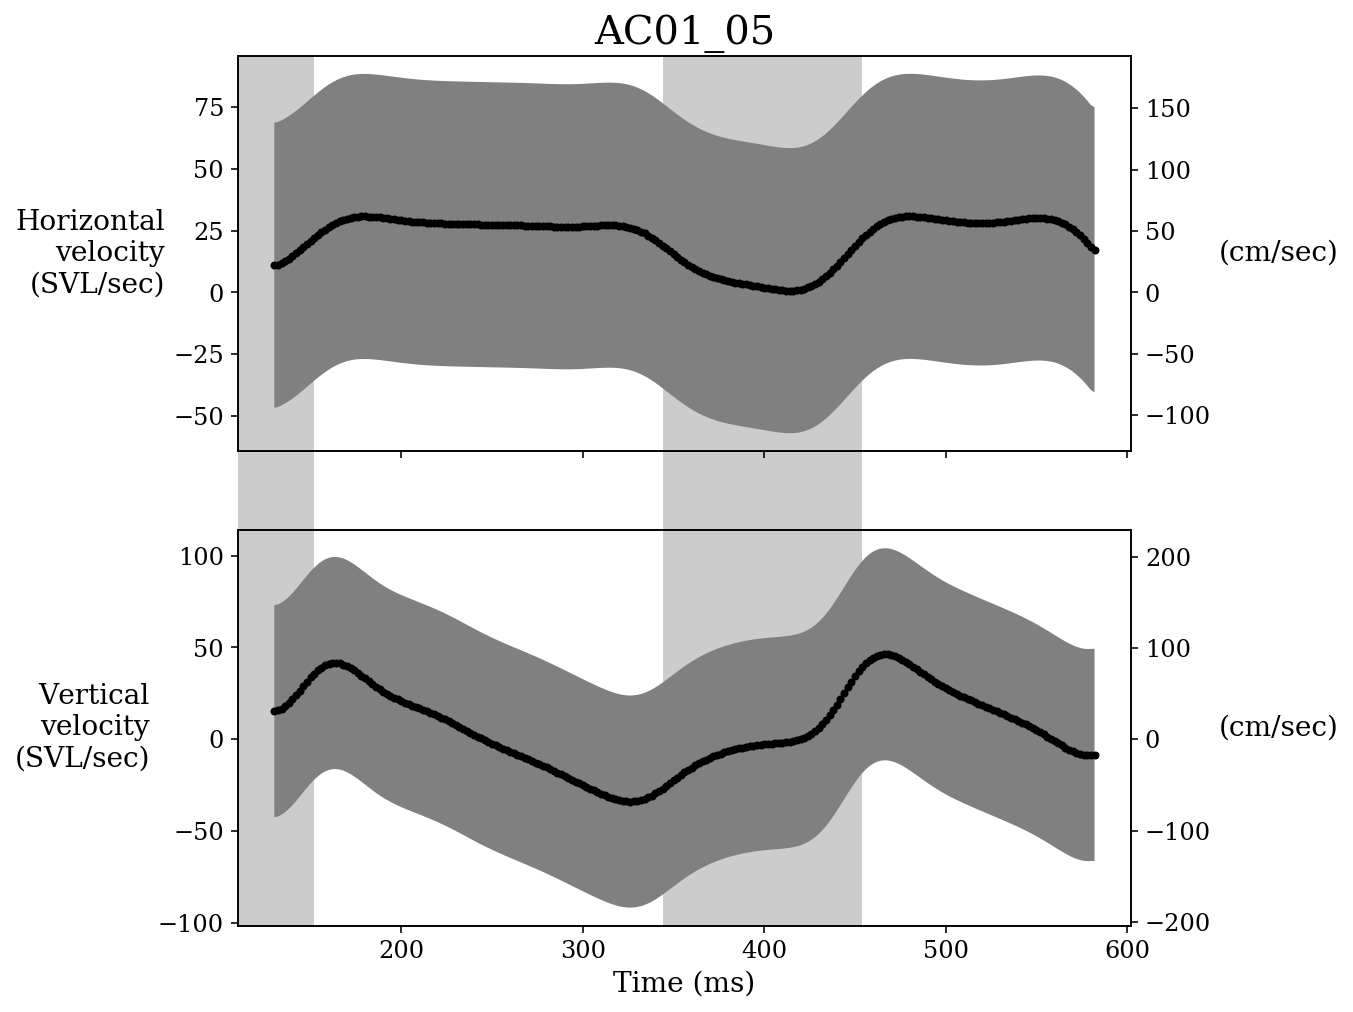

In [19]:
ax, fig = graph_vel('AC01_05')

In [122]:
fig.savefig('Figures/AC01_06_pos.pdf', edgecolor=None, facecolor=None, transparent=True, 
            frameon=False, bbox_inches='tight',format='pdf')

# AC01_04

In [1]:
data = loadSingleFrog('AC03_20')

NameError: name 'loadSingleFrog' is not defined

In [22]:
data['watercontactIdx'][0]

array([ 98, 144])

(0, 80)

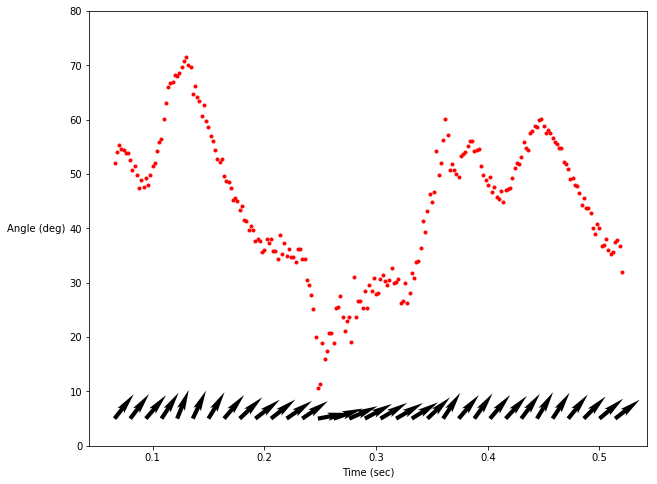

In [5]:
fig, ax = plt.subplots(nrows=1, sharex=True, figsize=(10, 8))

ax.plot(data['time'], data['mnta'], 'r.')
ax.quiver(data['time'][::7],np.ones(data['time'].shape)[::7] *5, np.cos(np.deg2rad(data['mnta']))[::7],np.sin(np.deg2rad(data['mnta']))[::7],
         headwidth=2, headlength=5)

ax.set_ylabel('Angle (deg)', rotation=0, va='center', ha='right')
ax.set_xlabel('Time (sec)')
ax.set_ylim([0, 80])

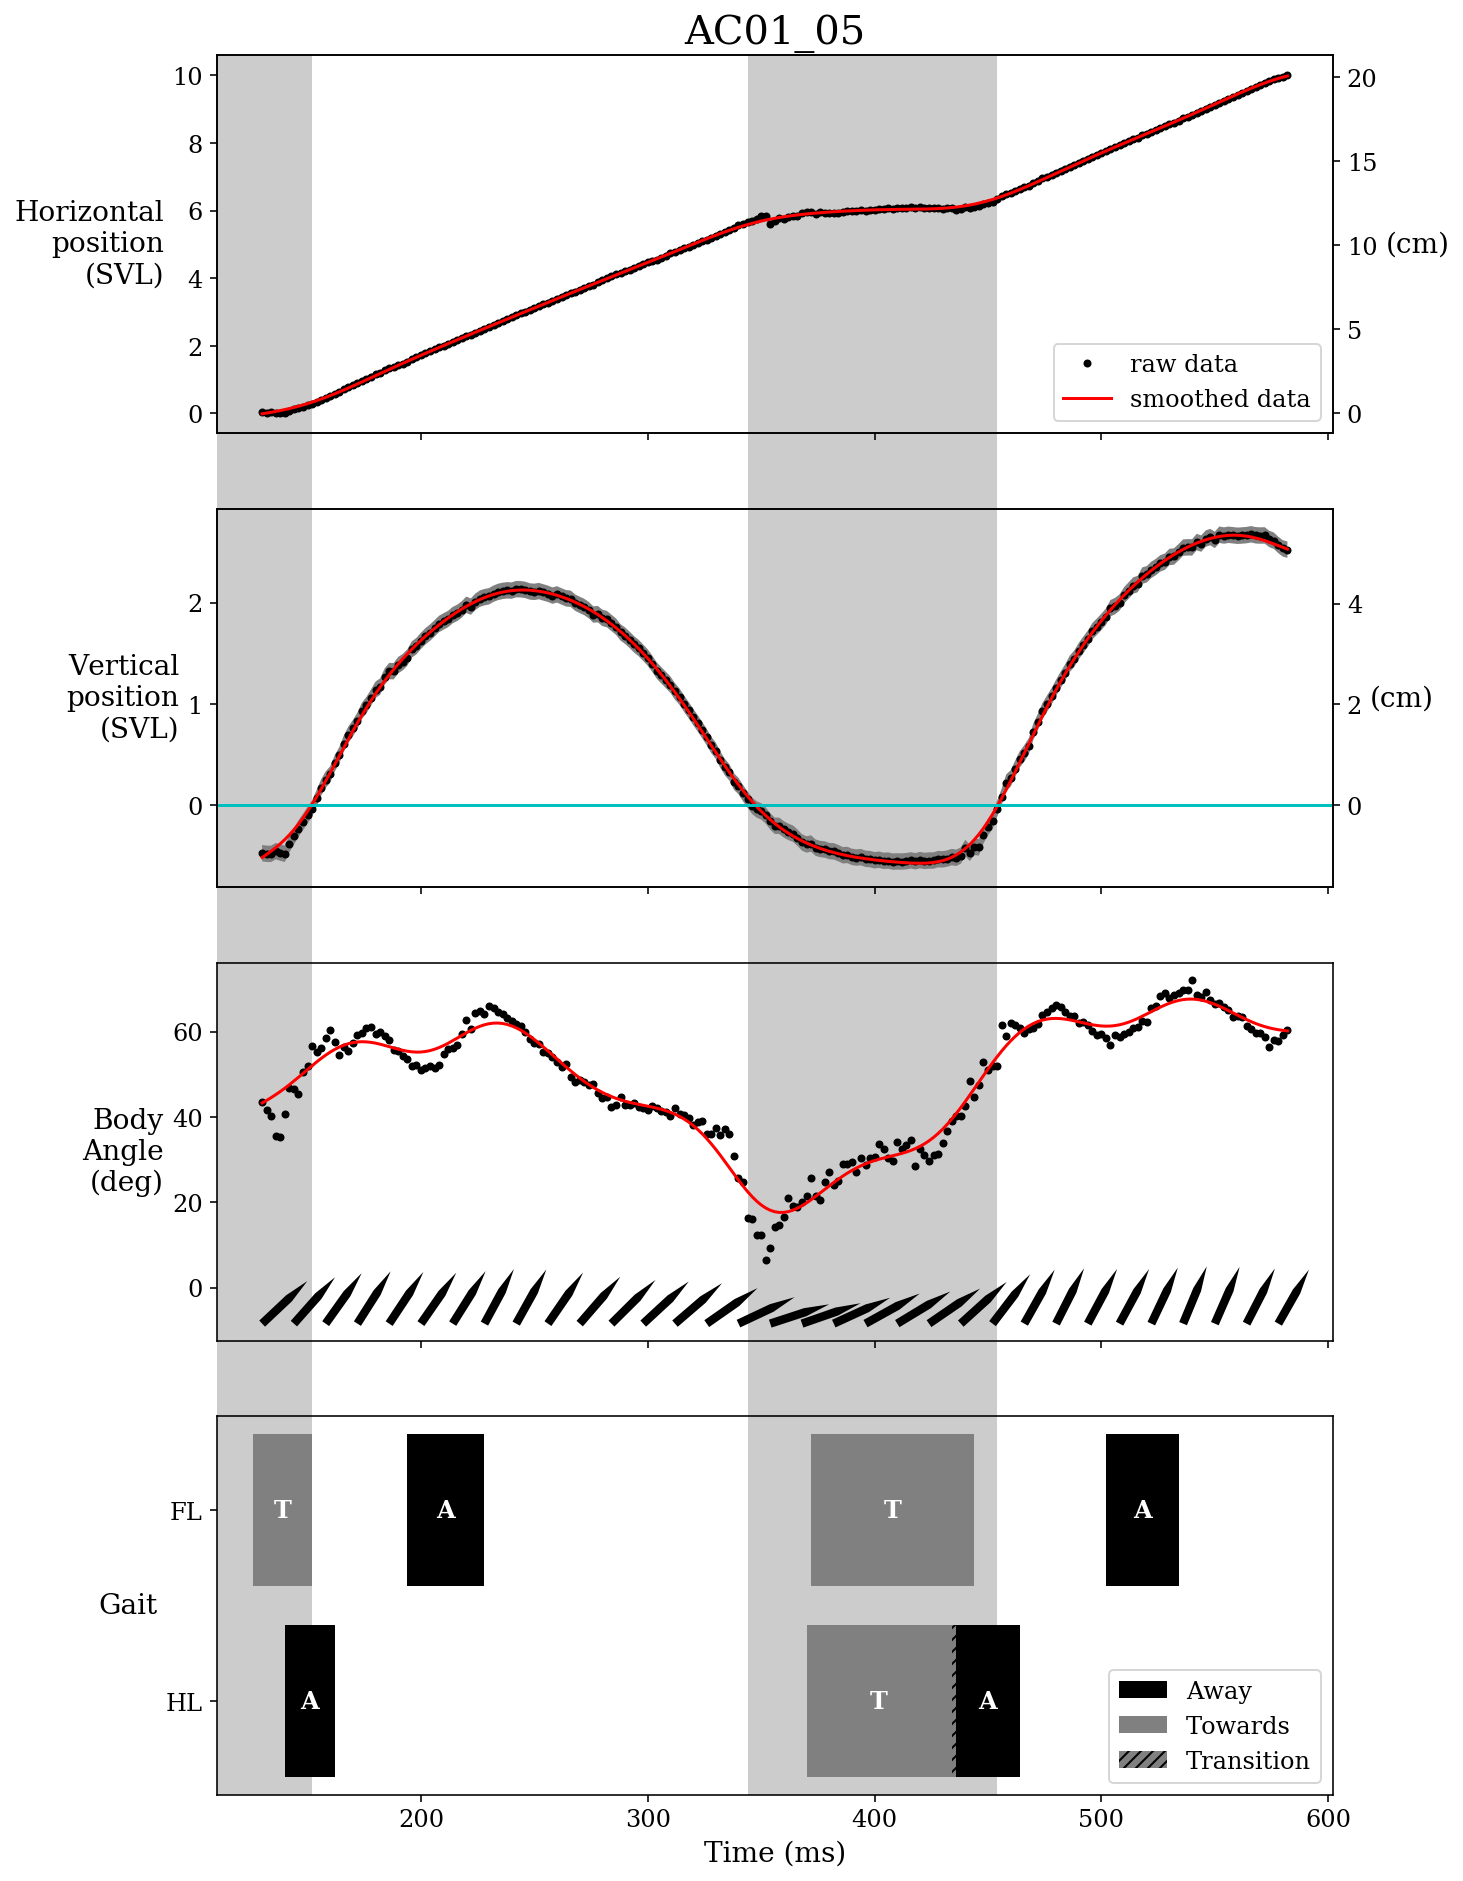

In [14]:
ax, fig = graph_all('AC01_05', rev=False)

In [49]:
for key in data_allfiles.keys():
    print(key)

AC03_22
AC03_20
AC03_04
AC01_05
AC01_10
AC03_15
AC03_06
AC01_06
AC03_14
AC01_04
AC03_21
AC03_23
AC03_18
AC03_09
AC04_03


In [137]:
a2.

In [124]:
m.get_edgecolor()

(0.0, 0.0, 0.0, 0.0)

/home/talcat/.virtualenvs/py3-cv/lib/python3.5/site-packages/imageio/plugins/_tifffile.py:4247: UserWarning:

unexpected end of lzw stream (code 0)

/home/talcat/.virtualenvs/py3-cv/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



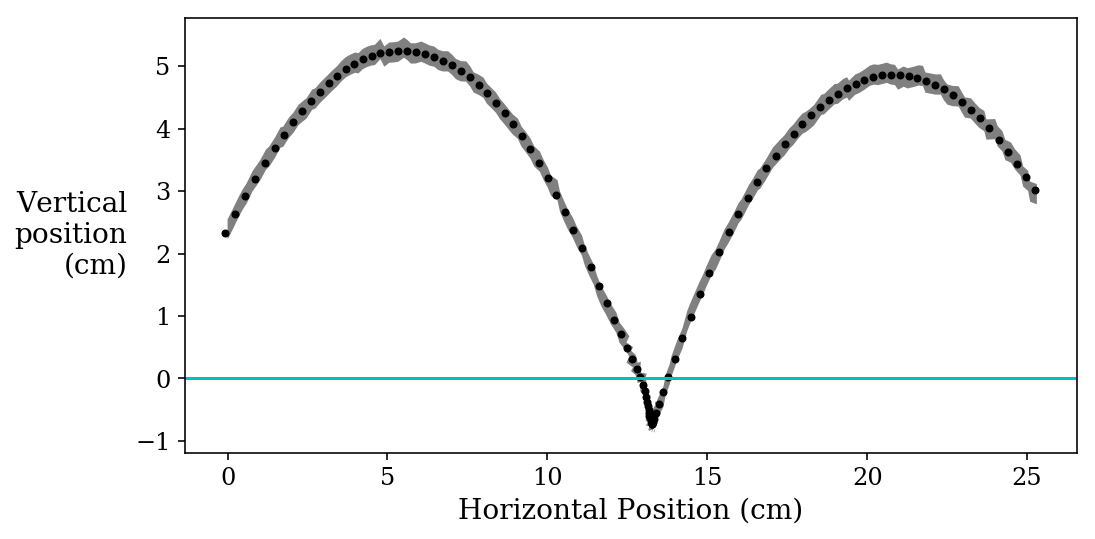

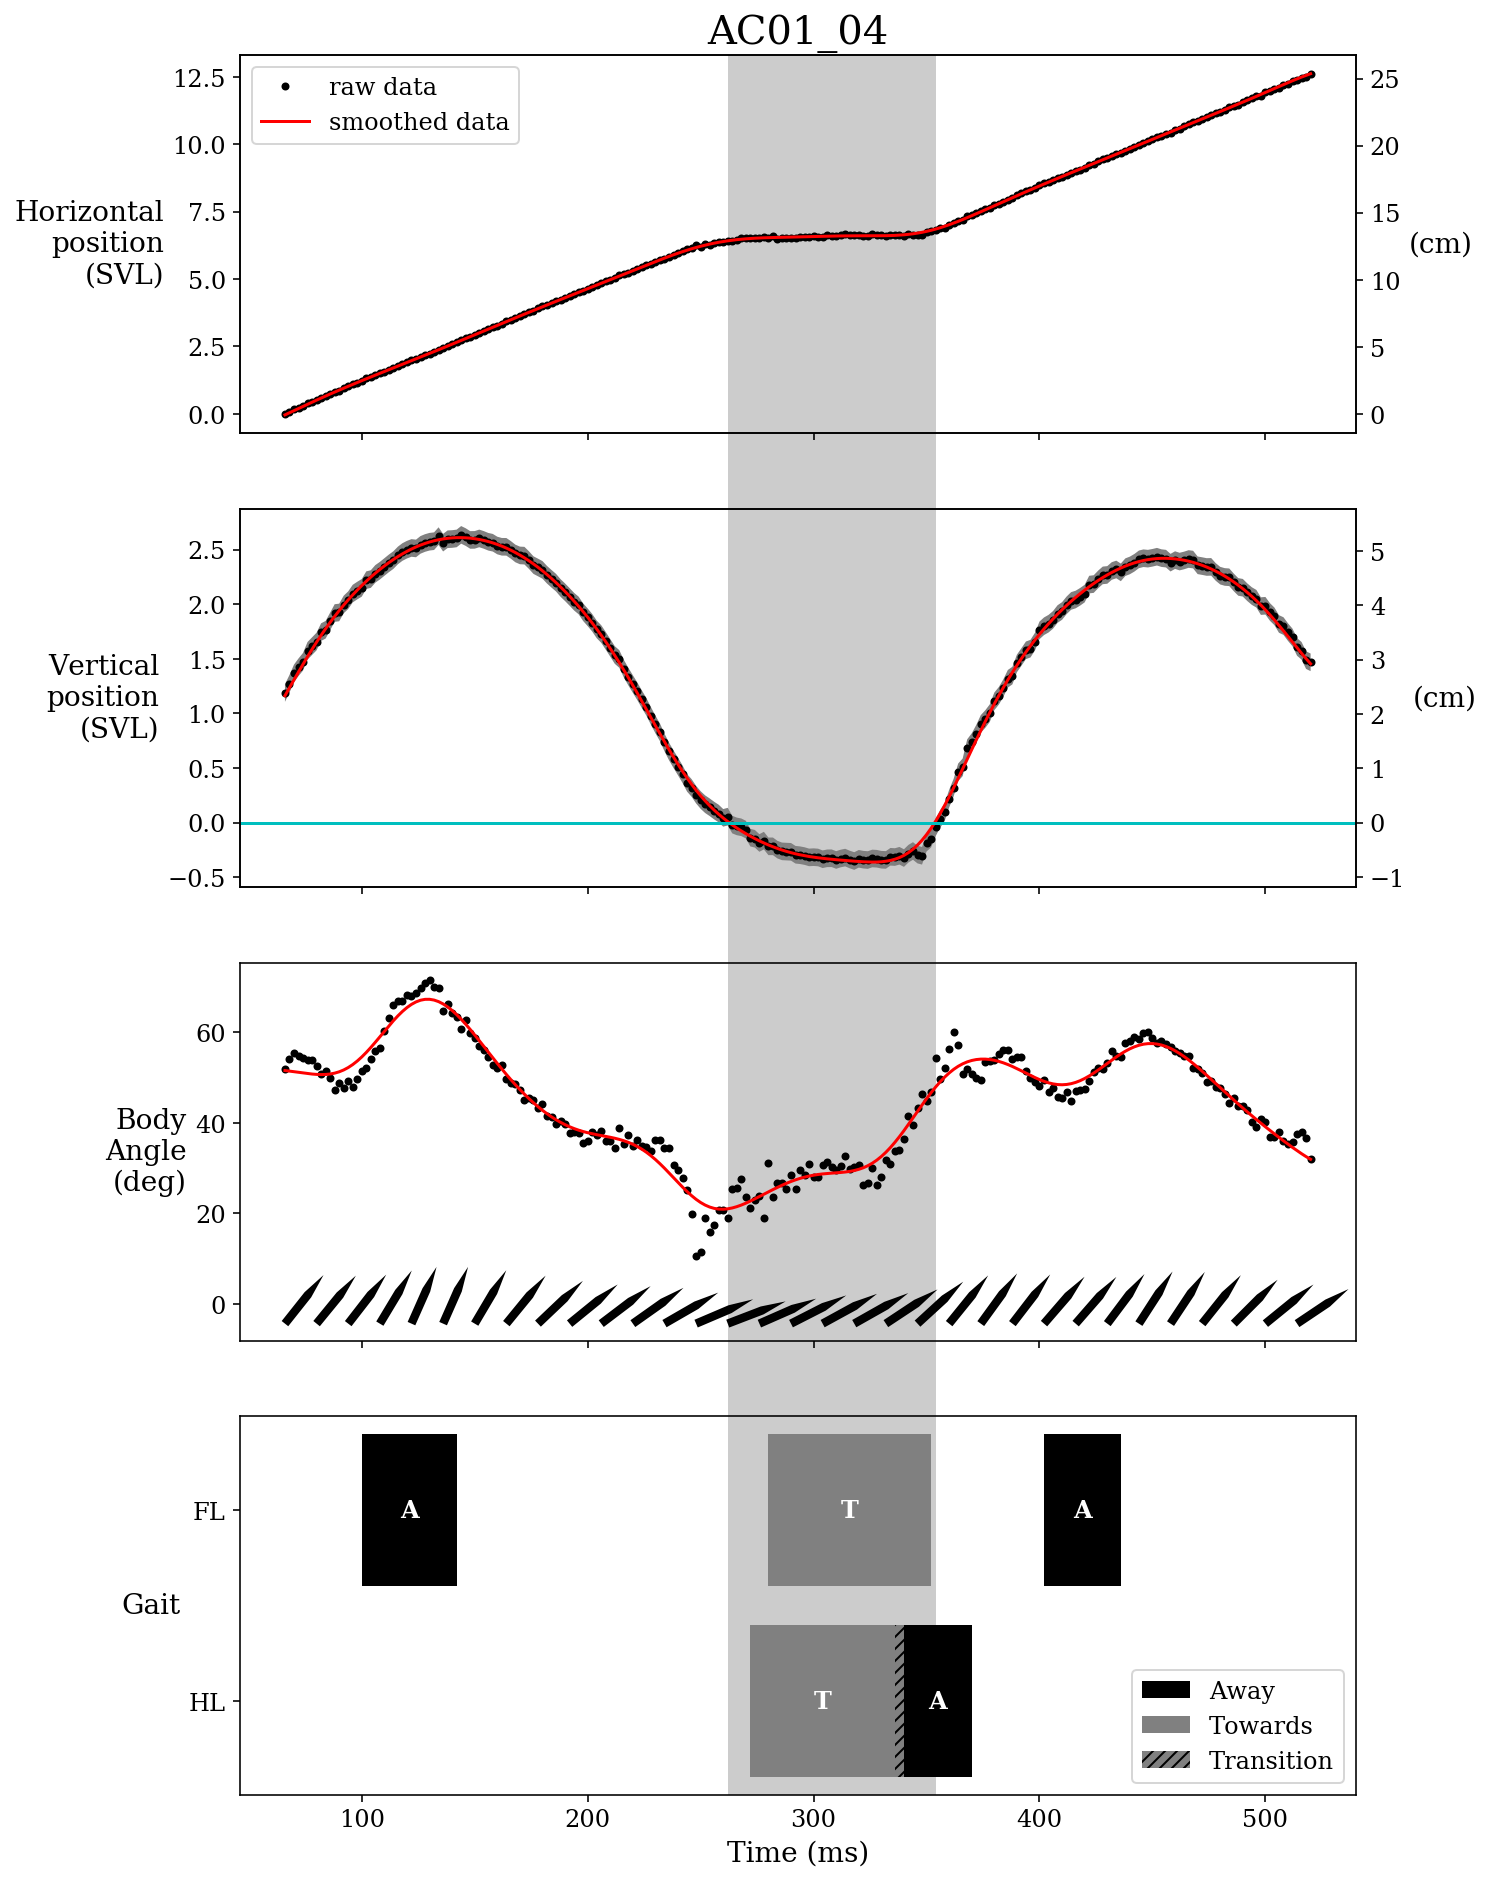

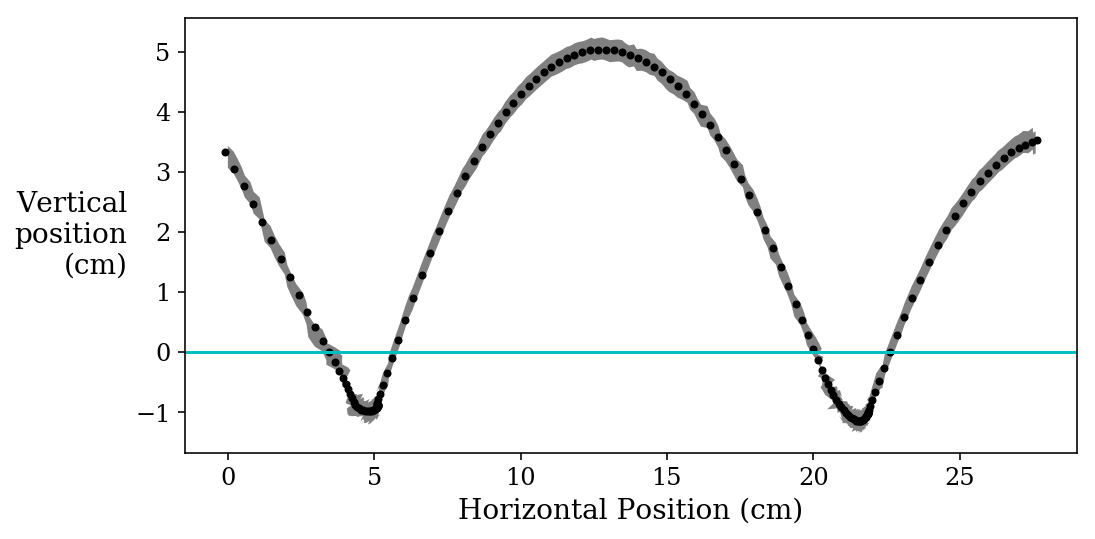

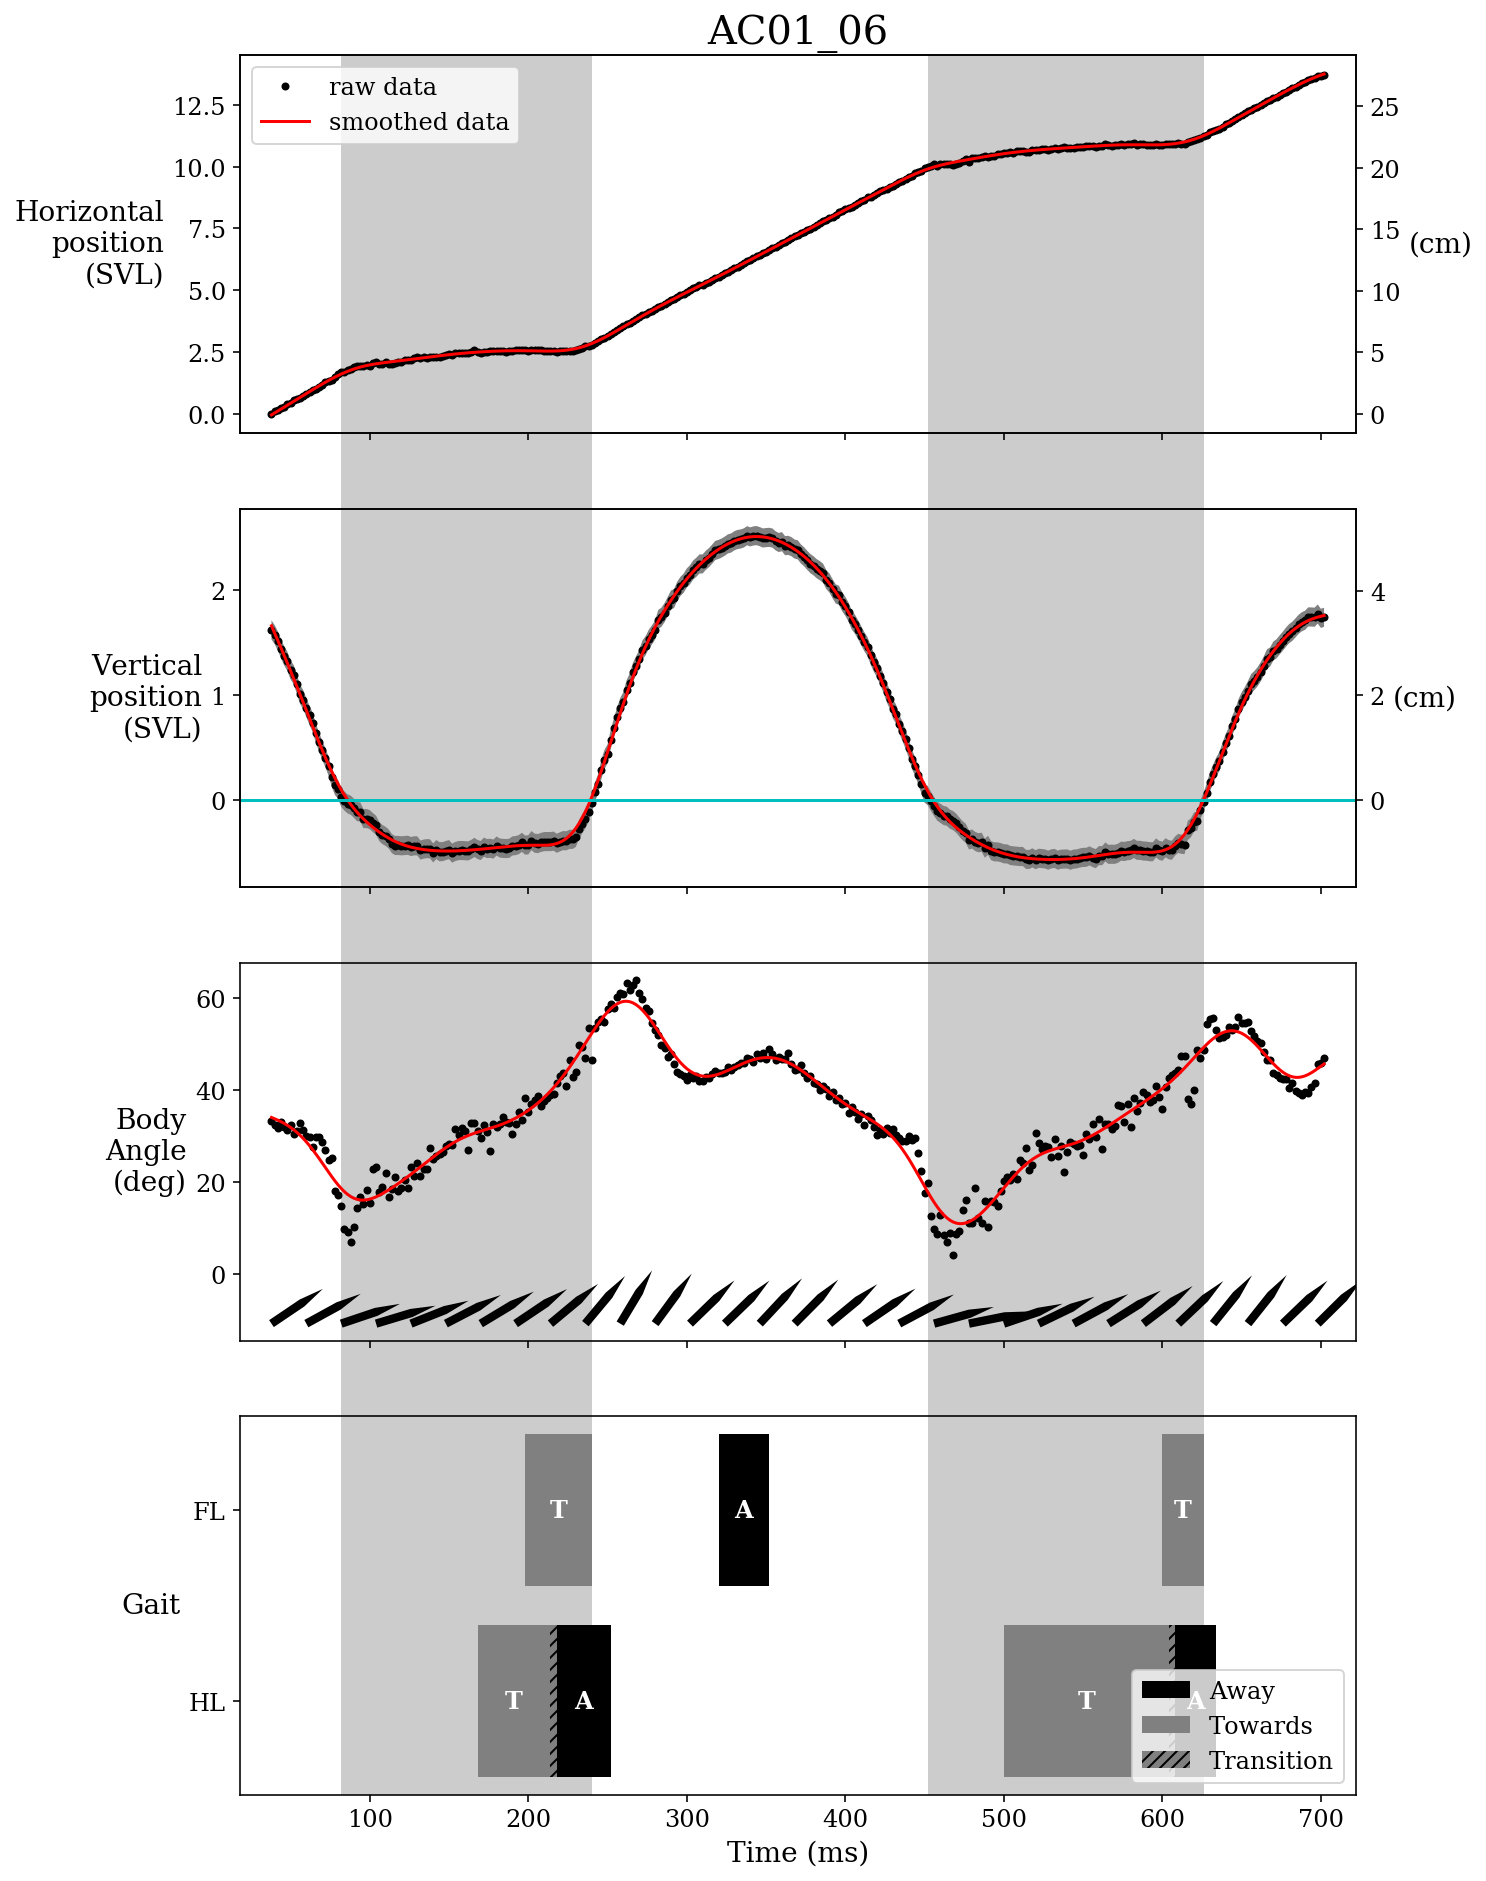

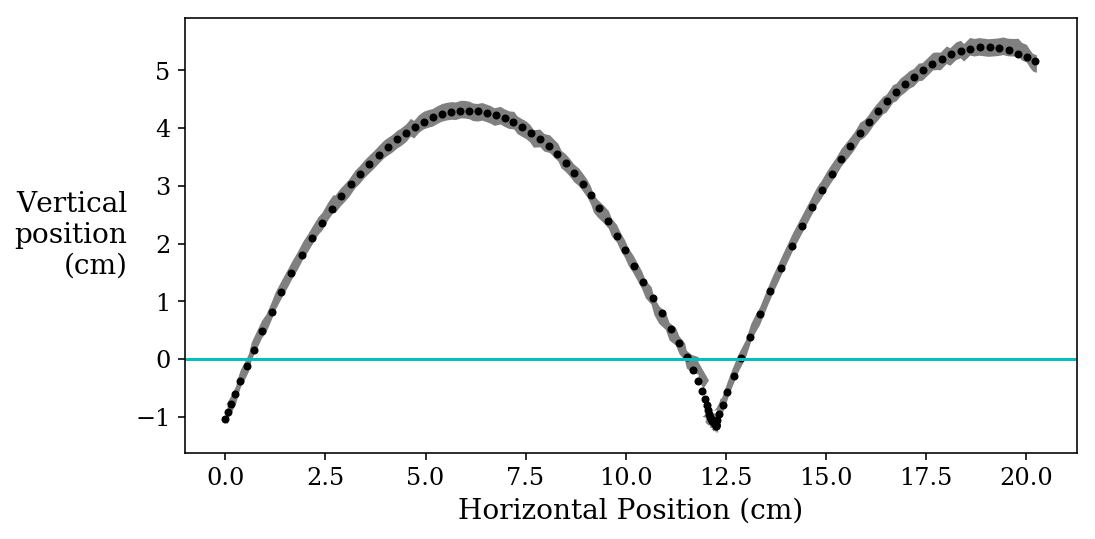

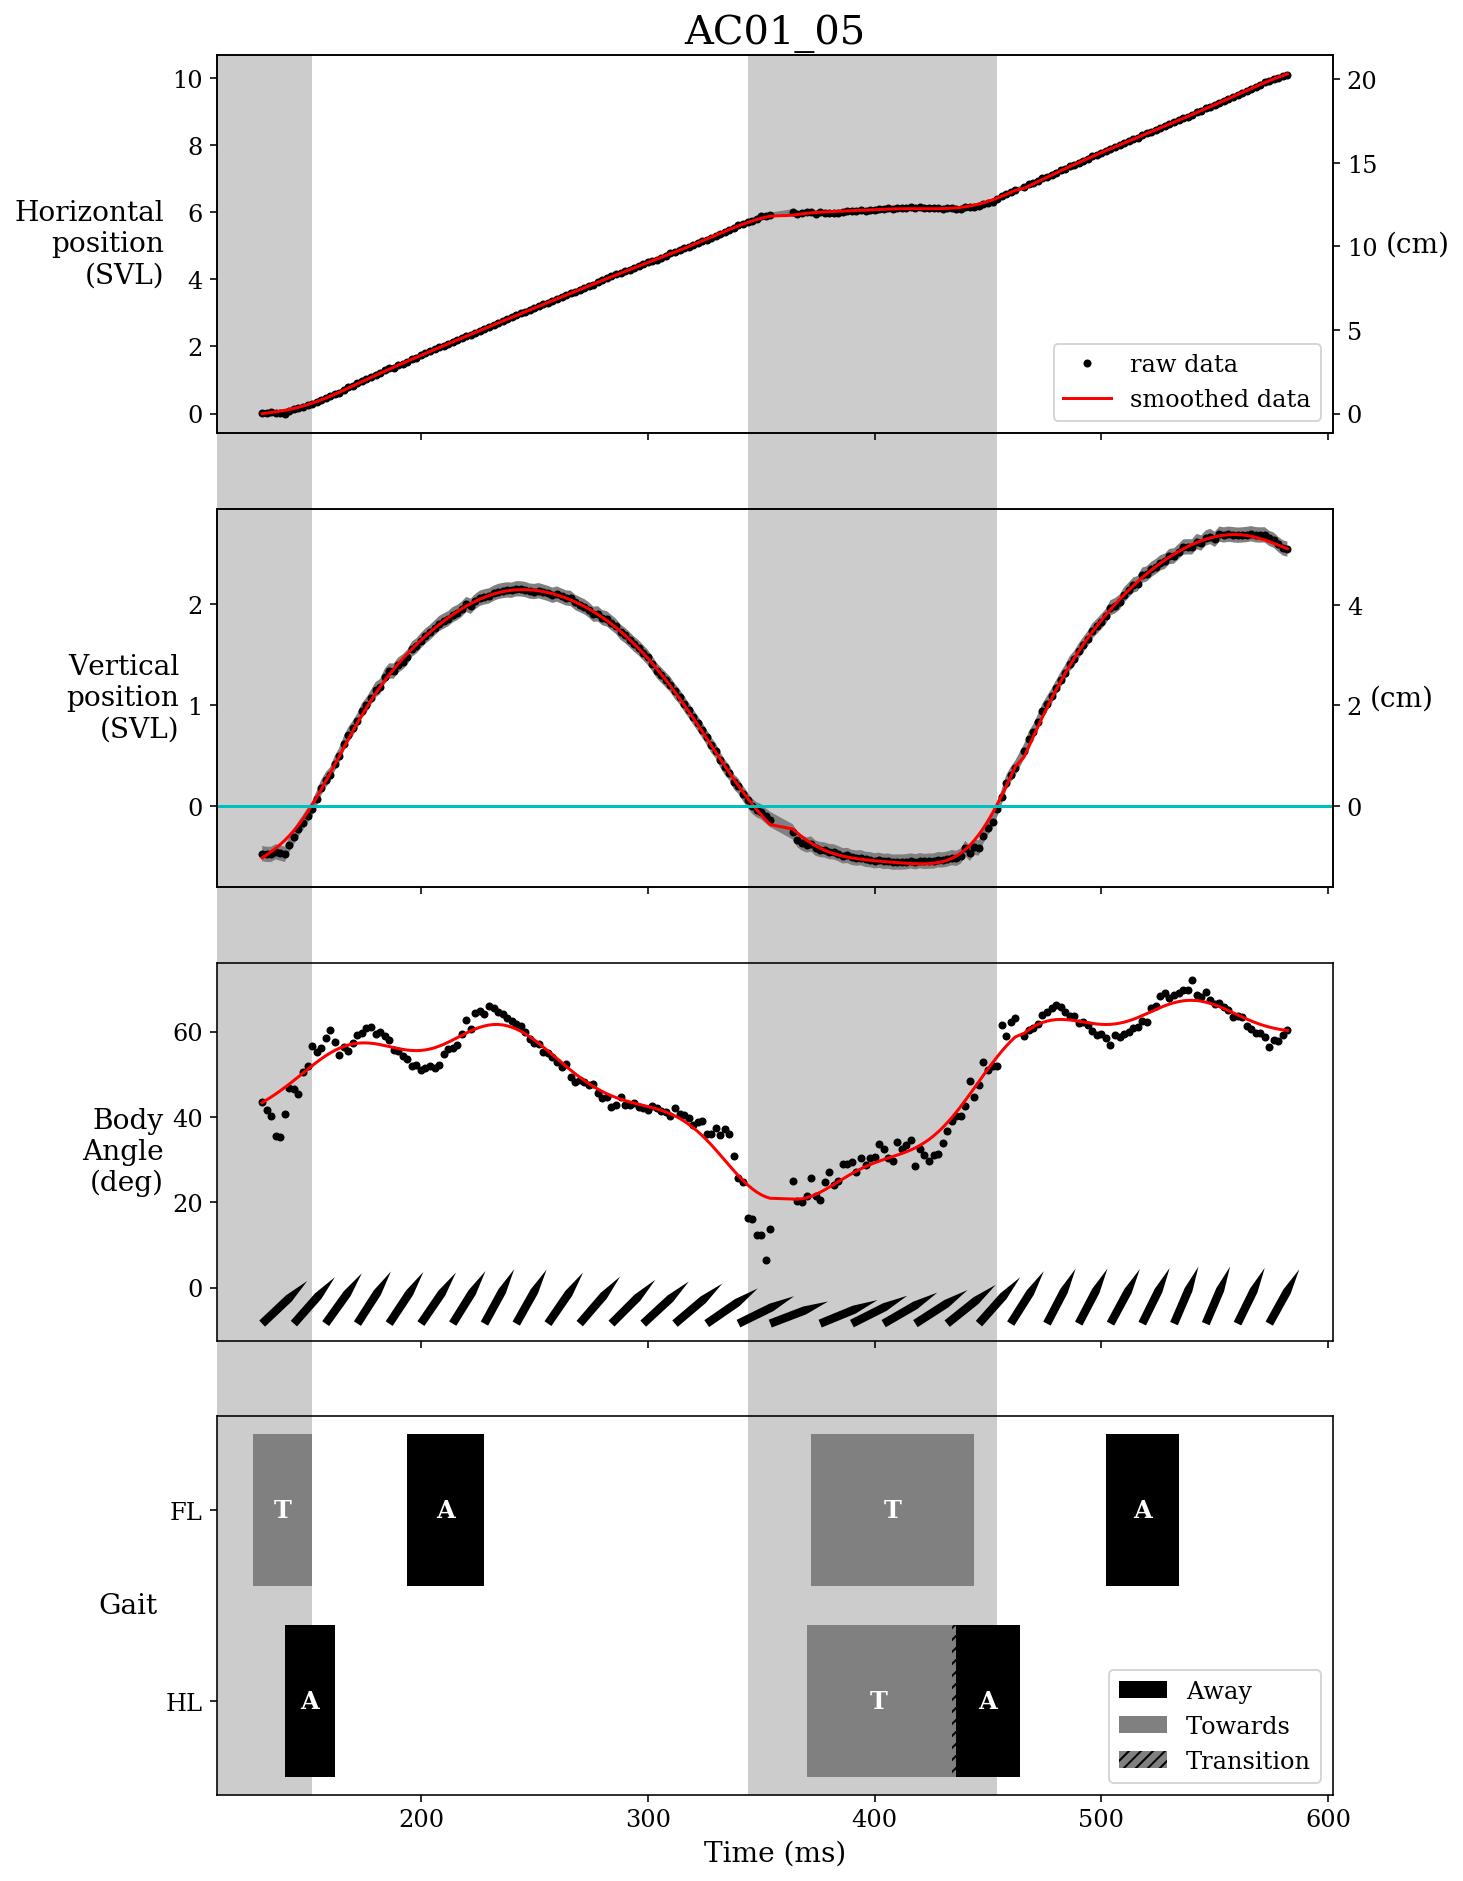

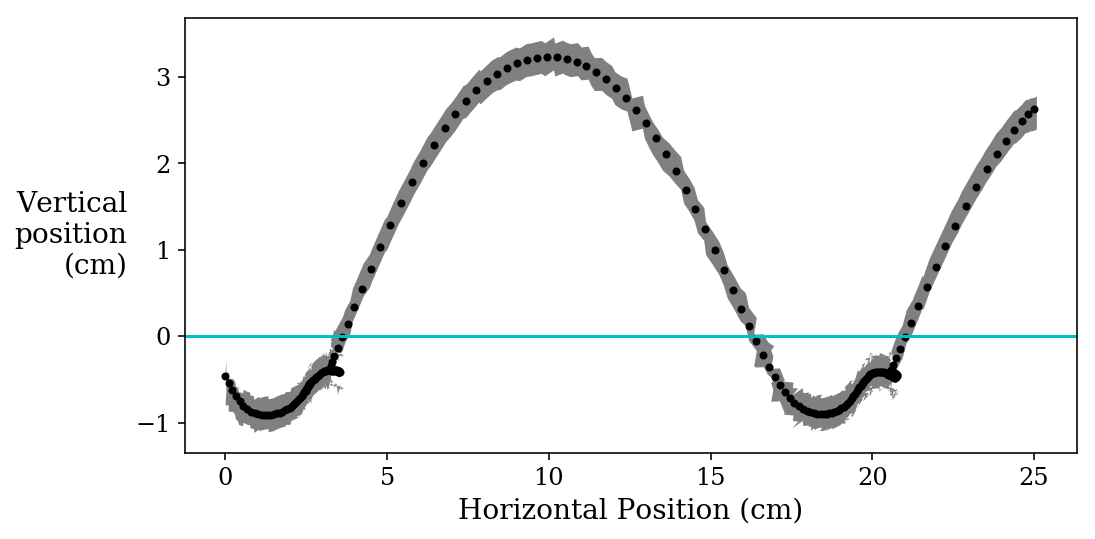

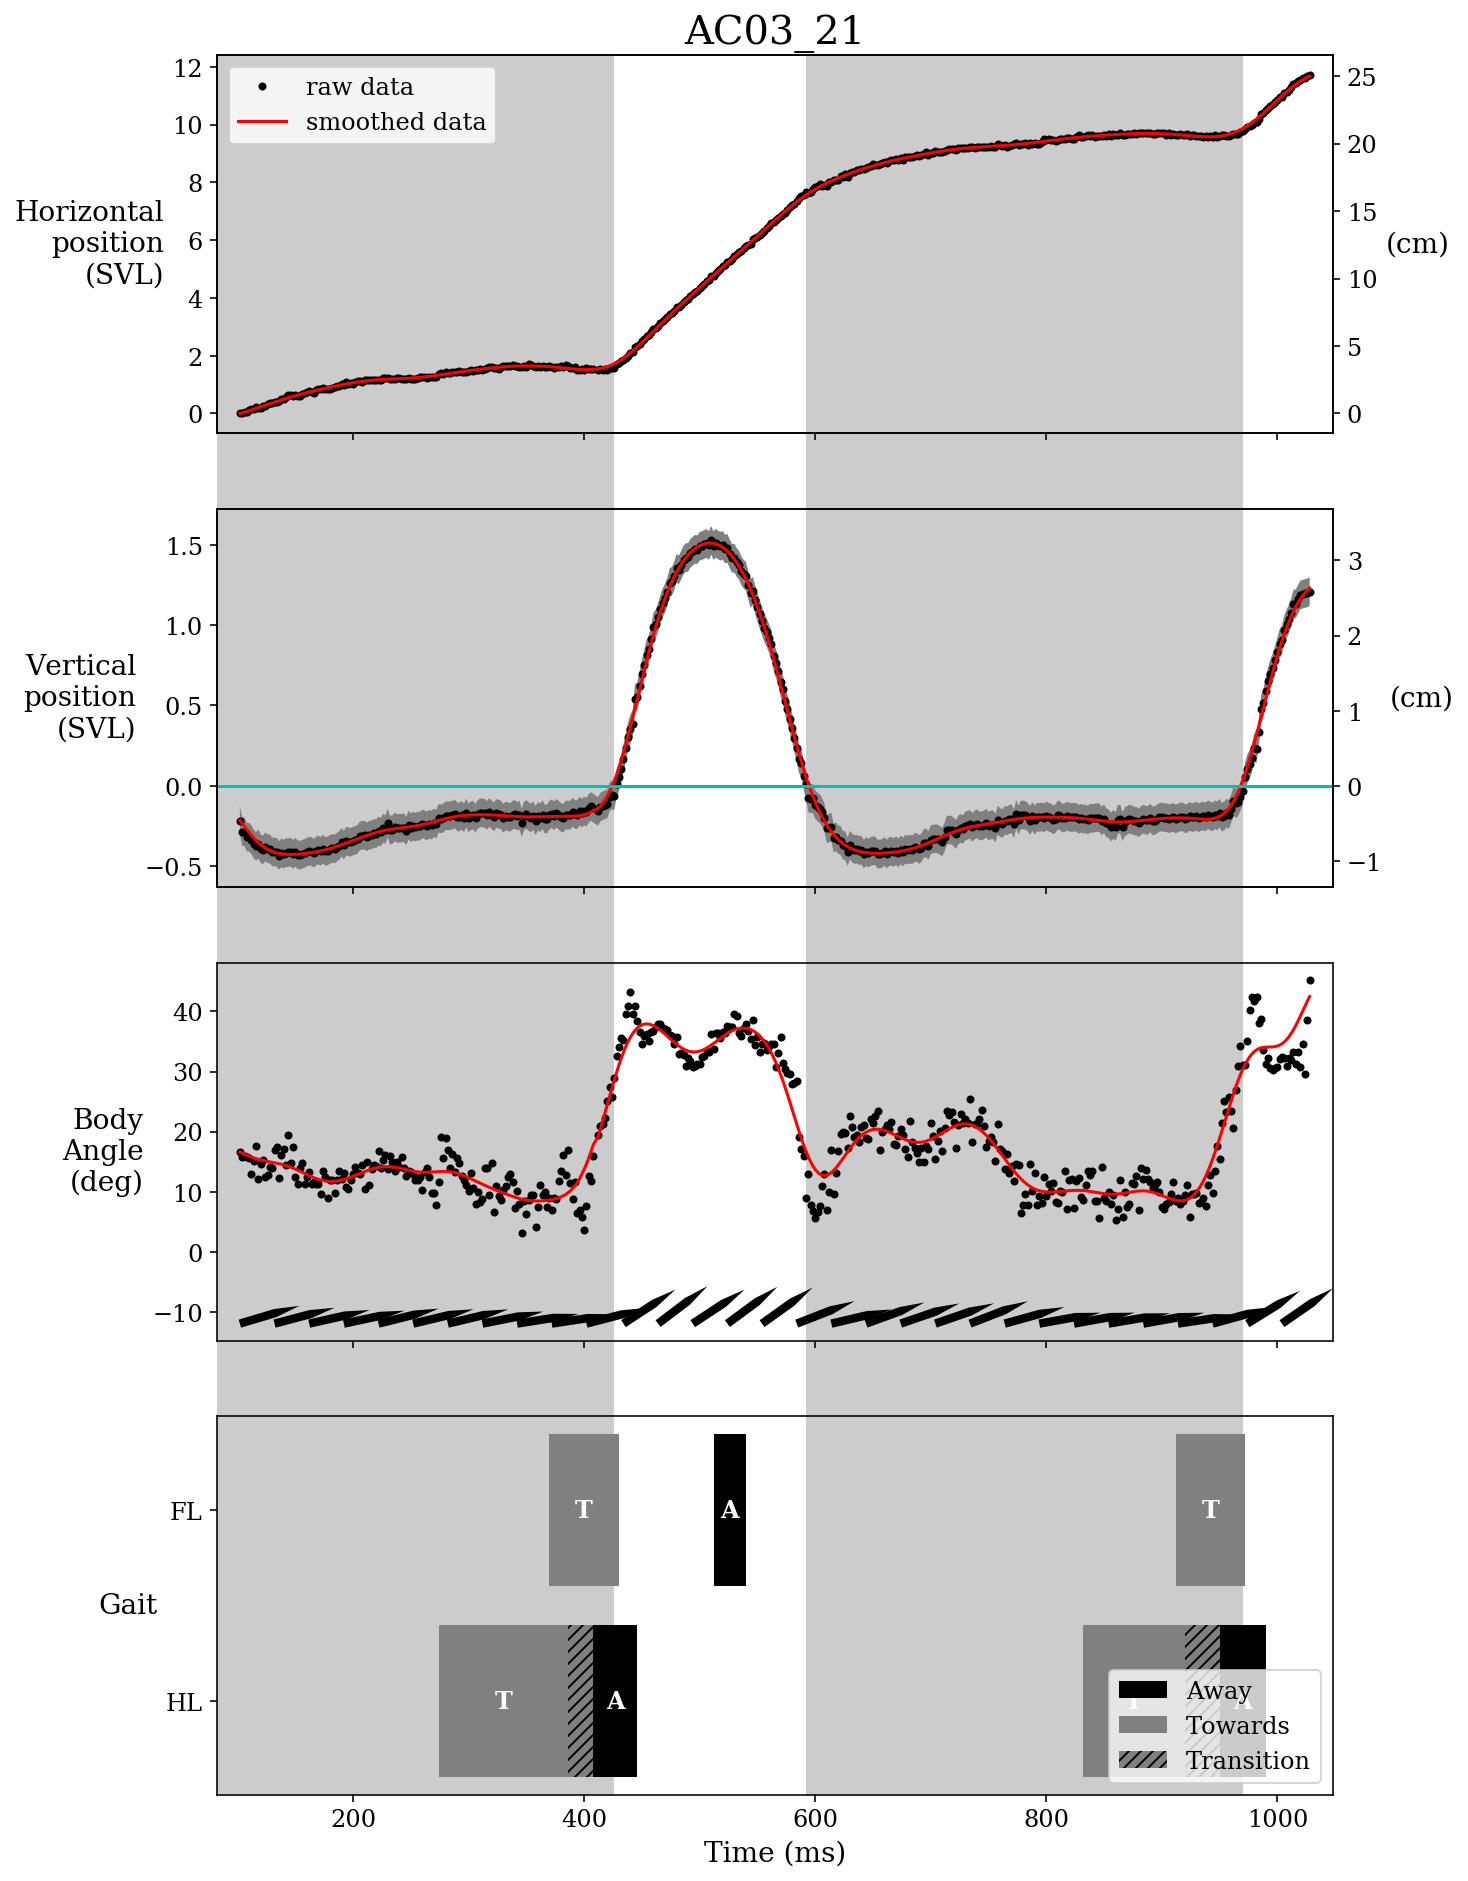

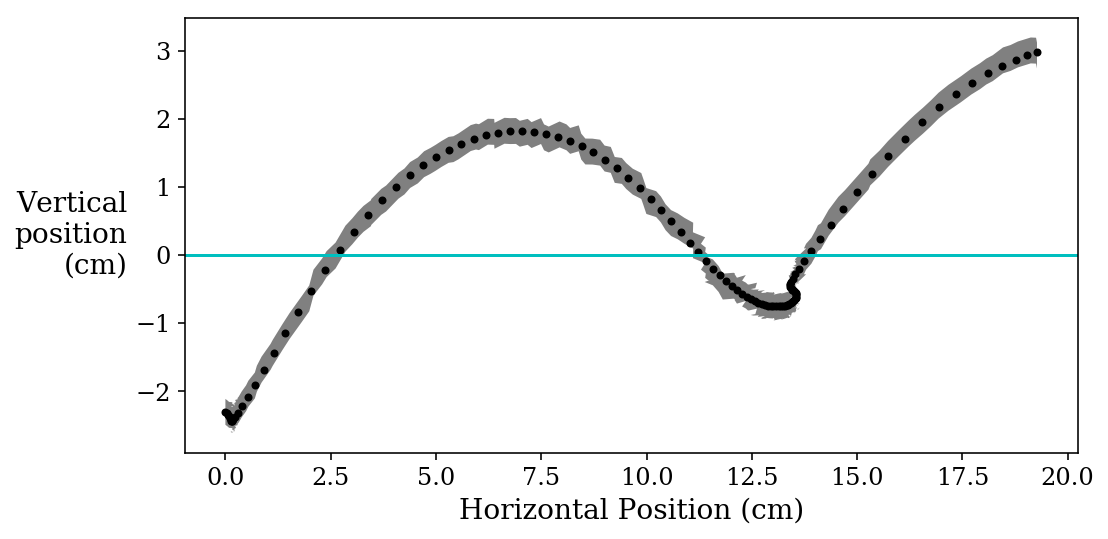

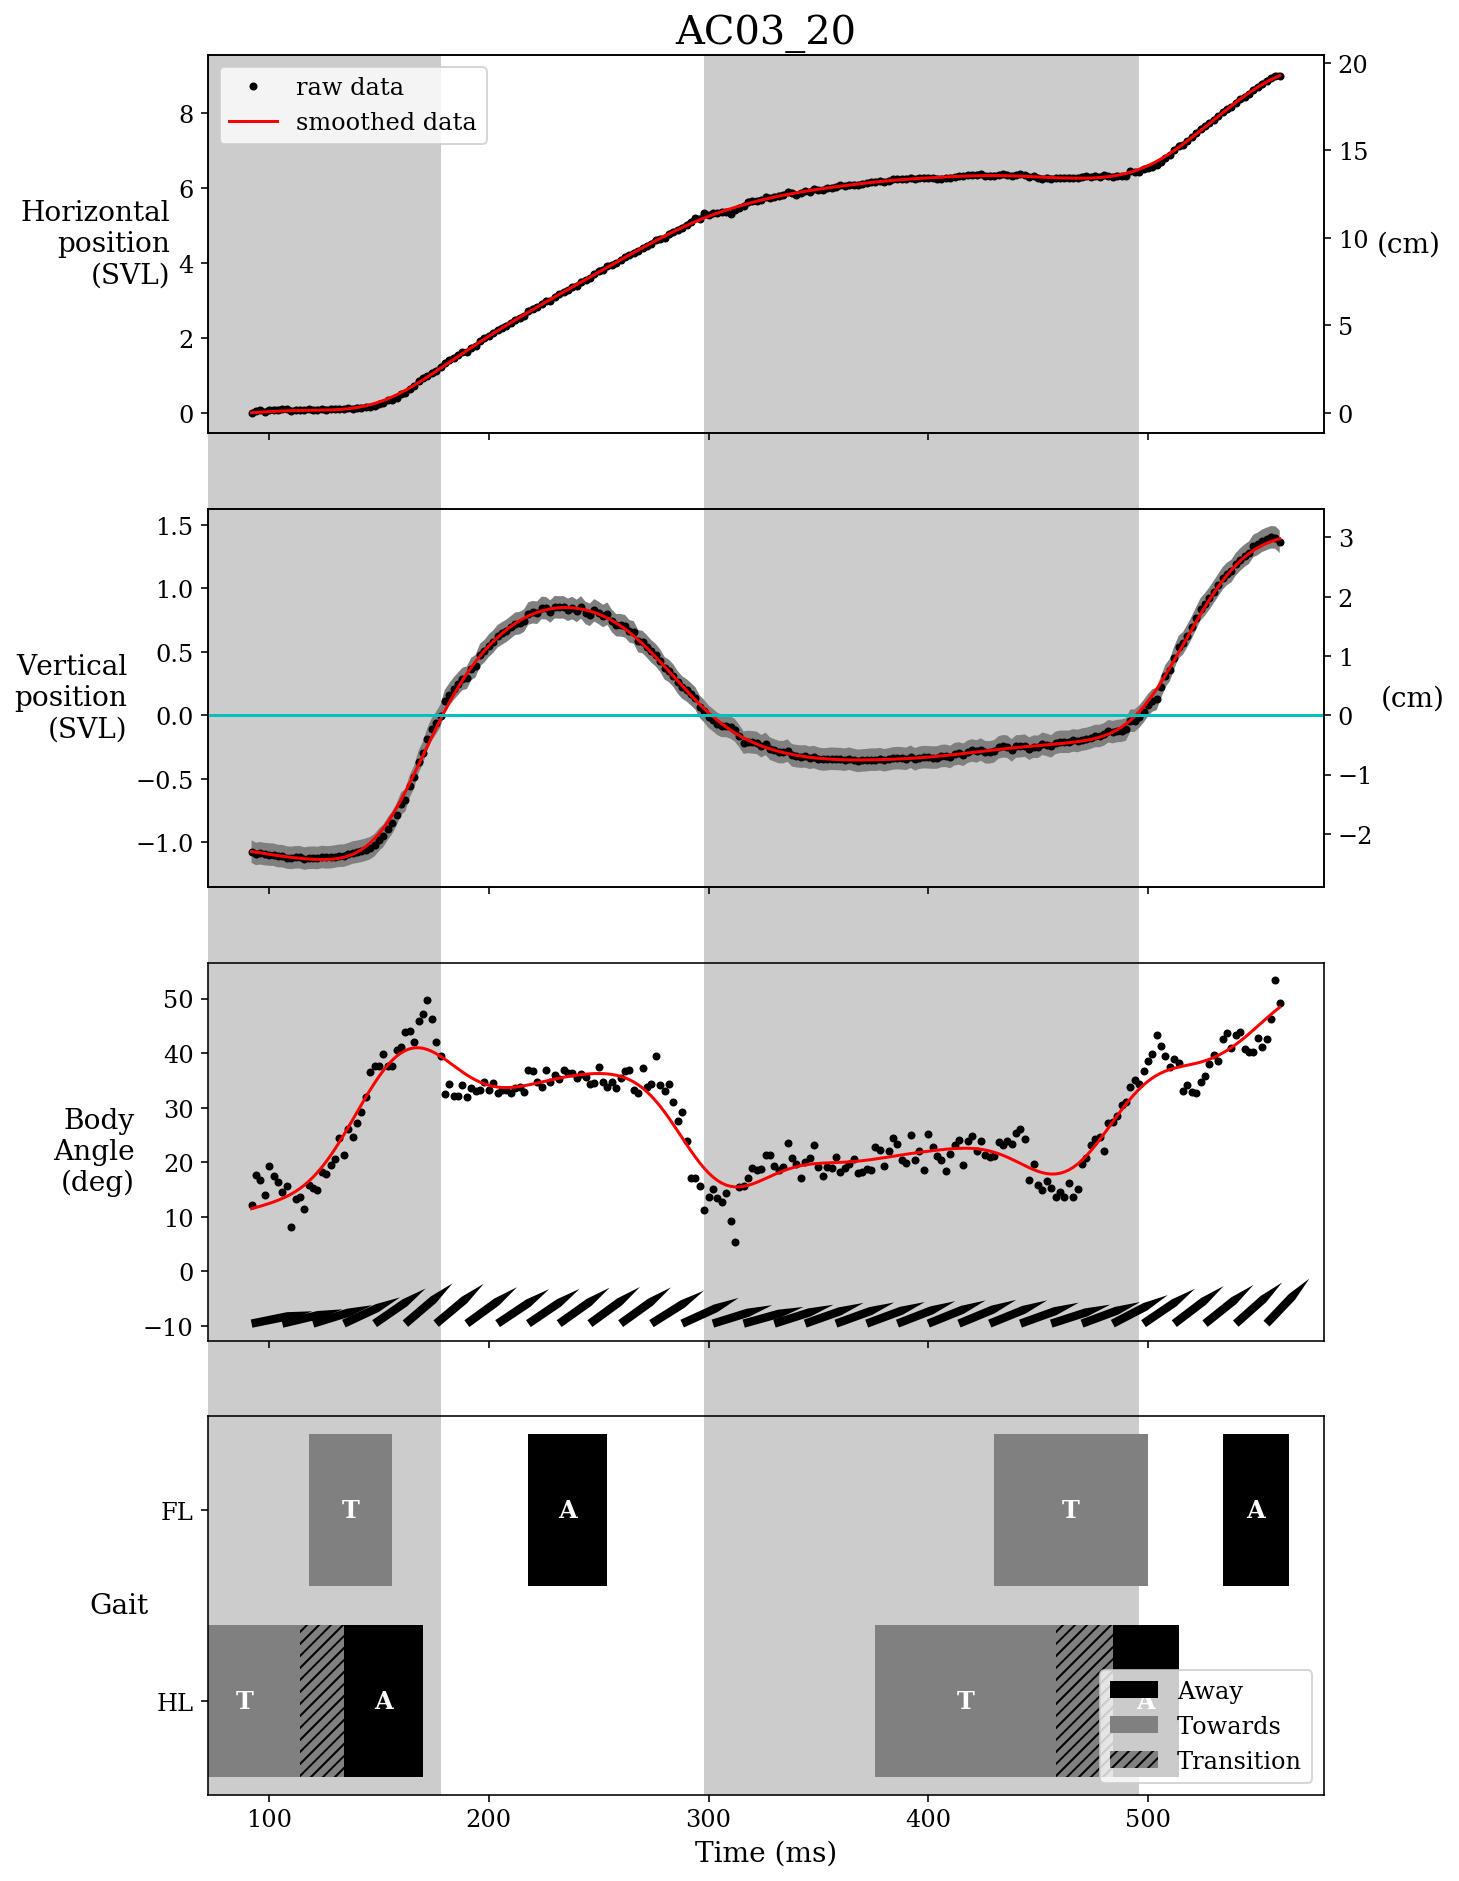

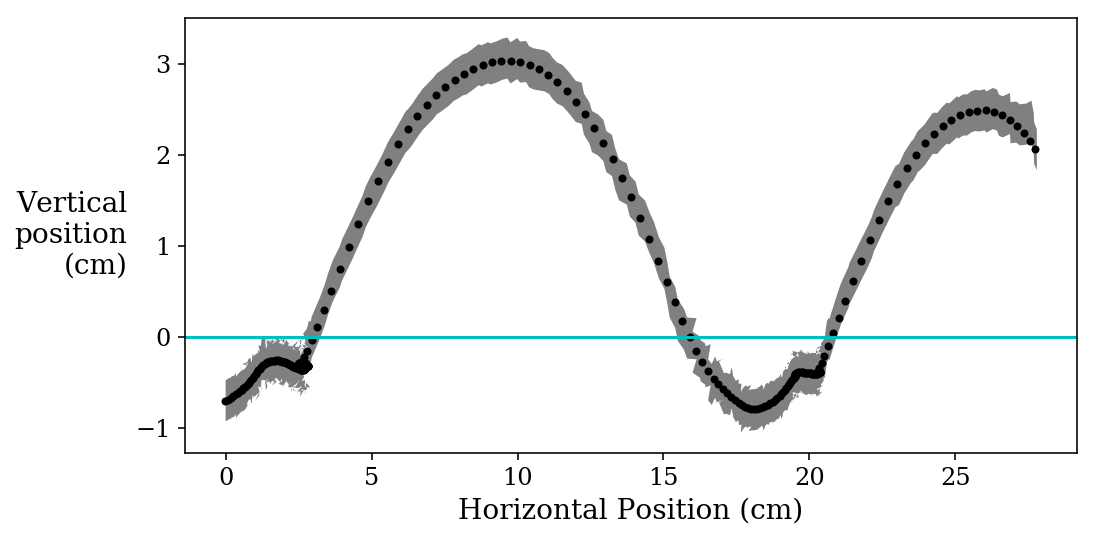

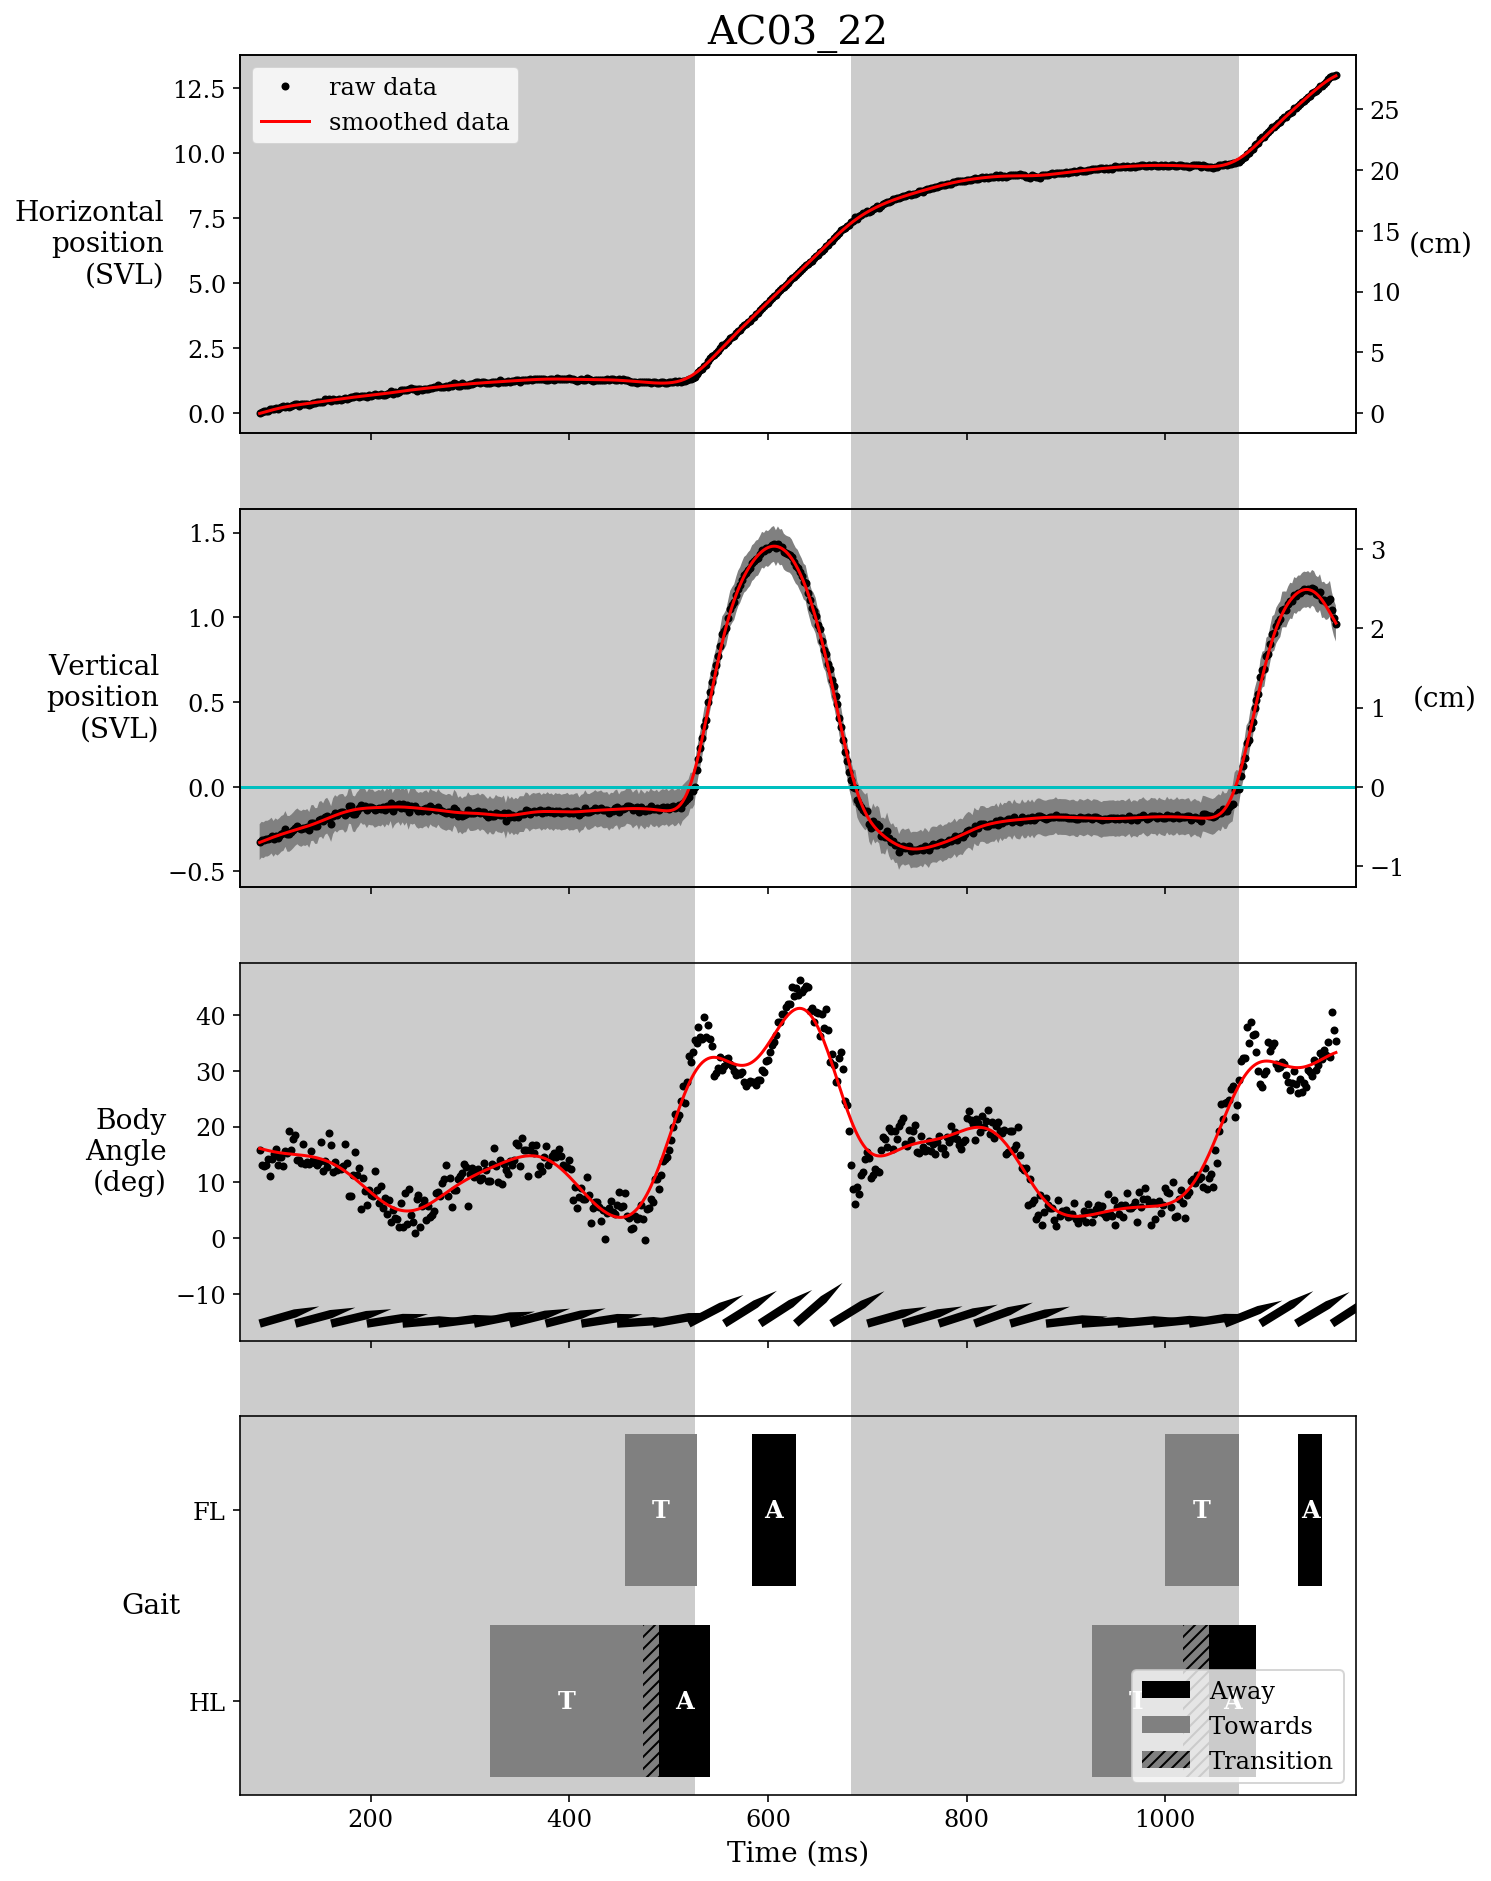

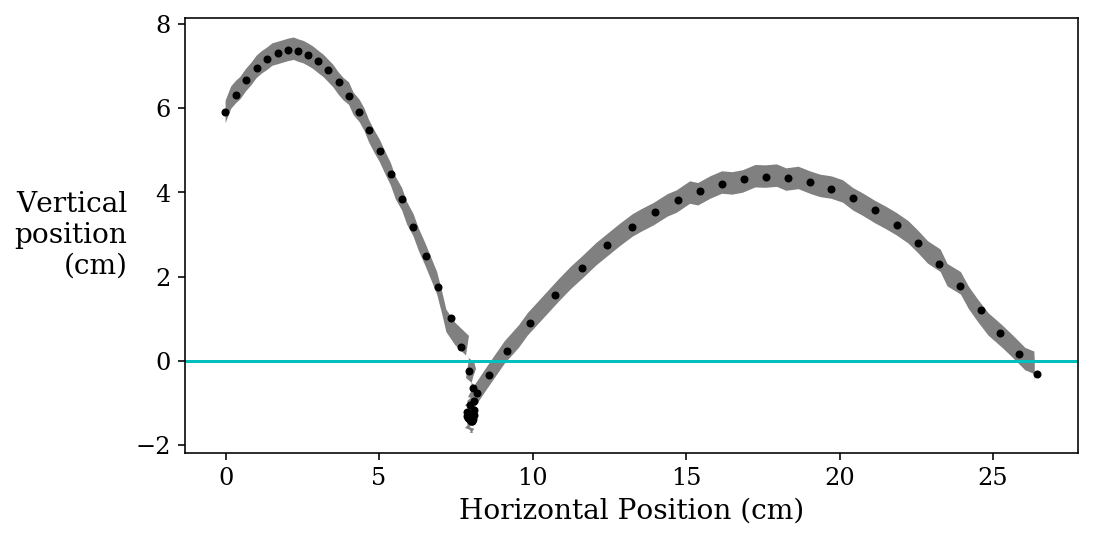

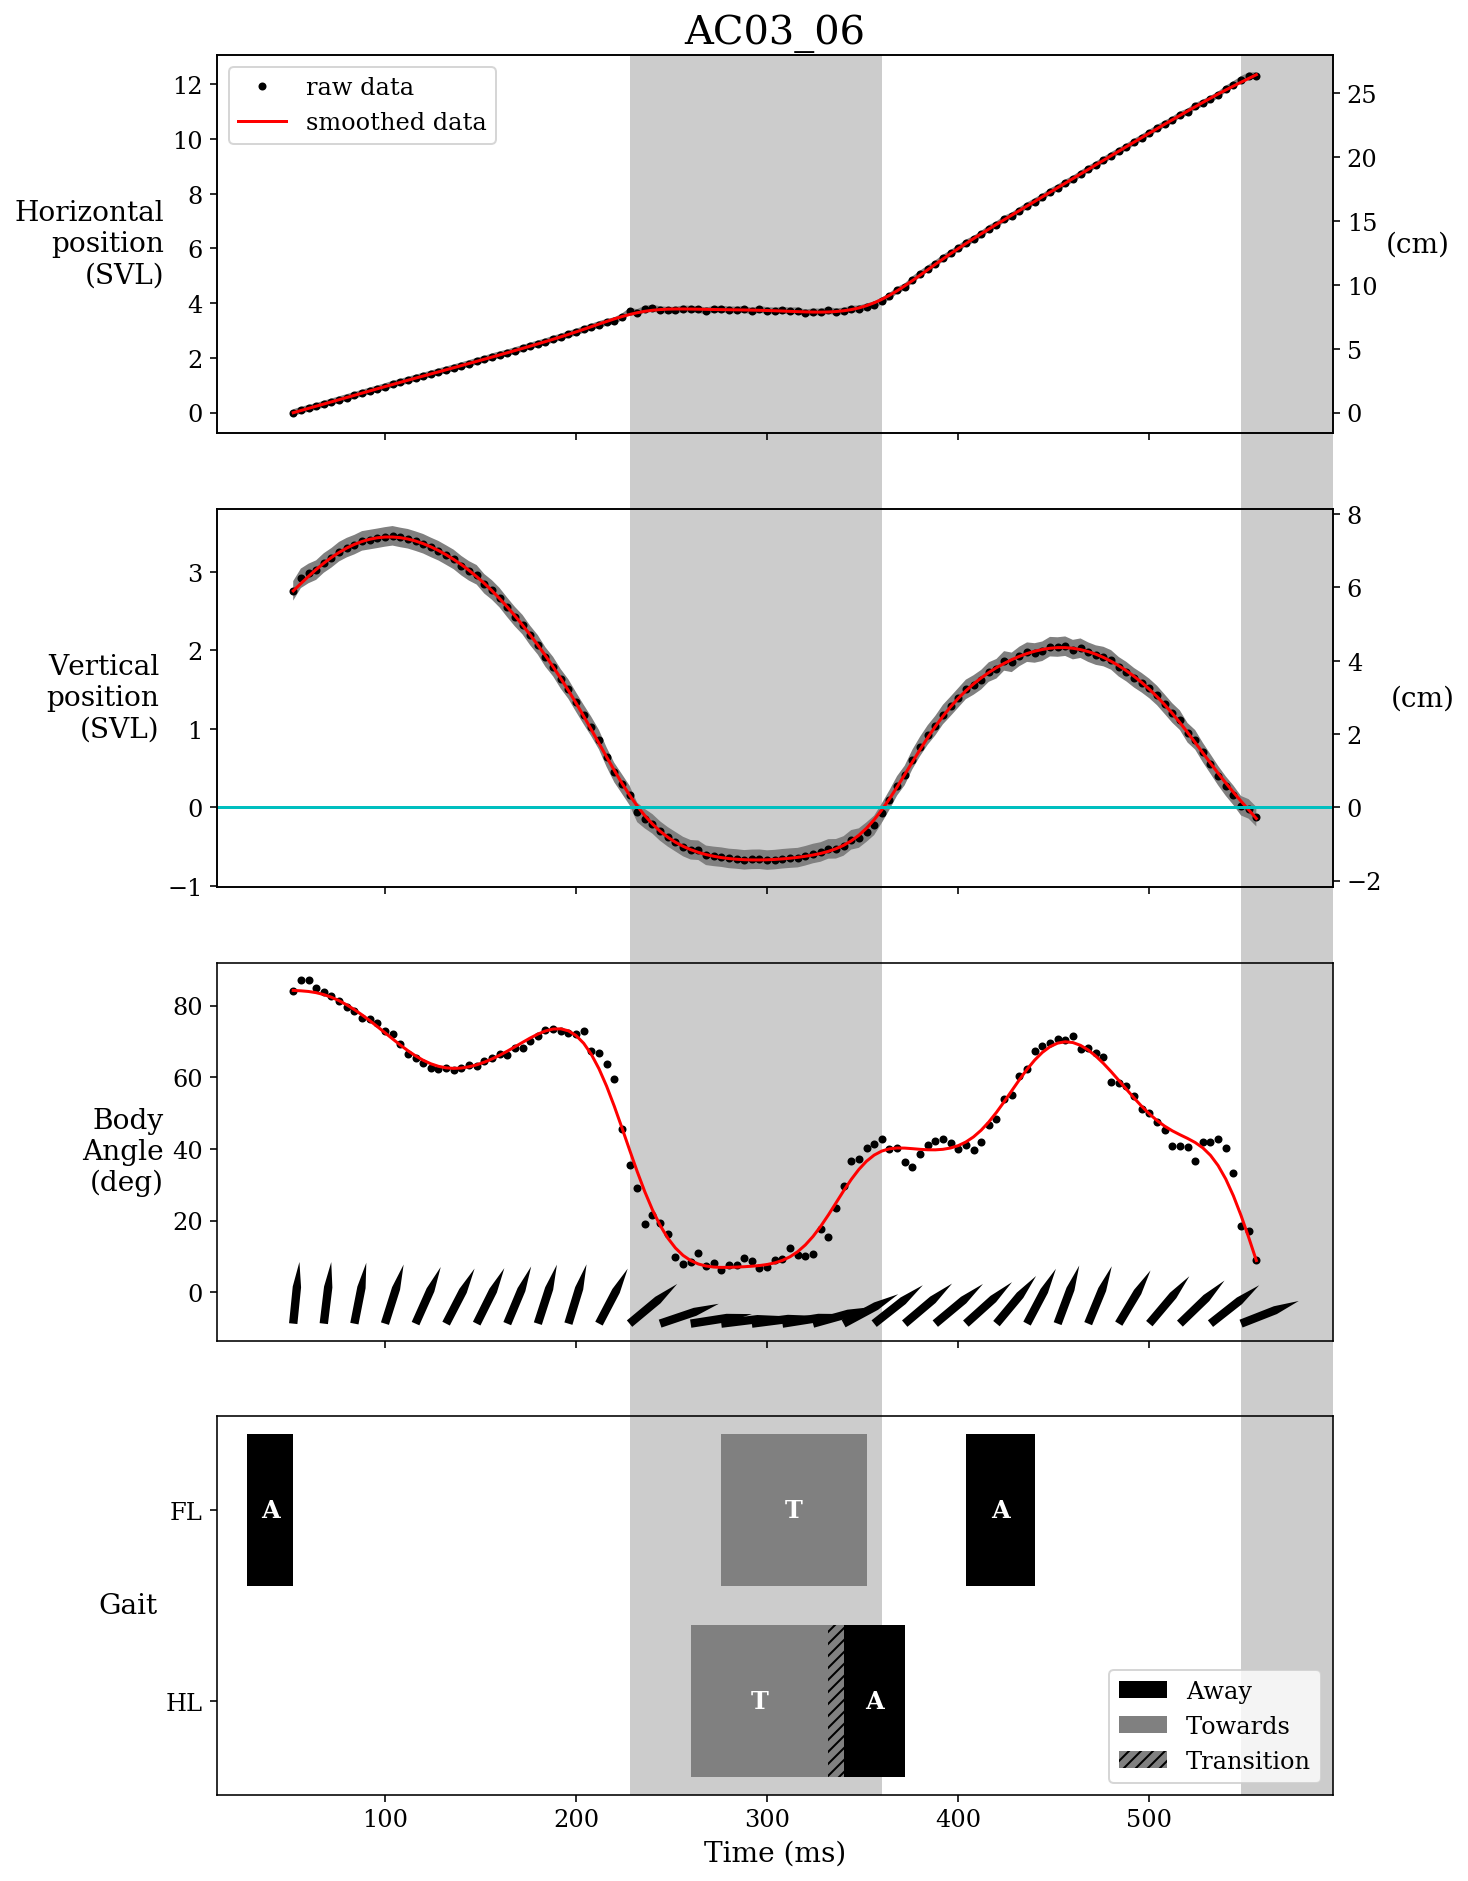

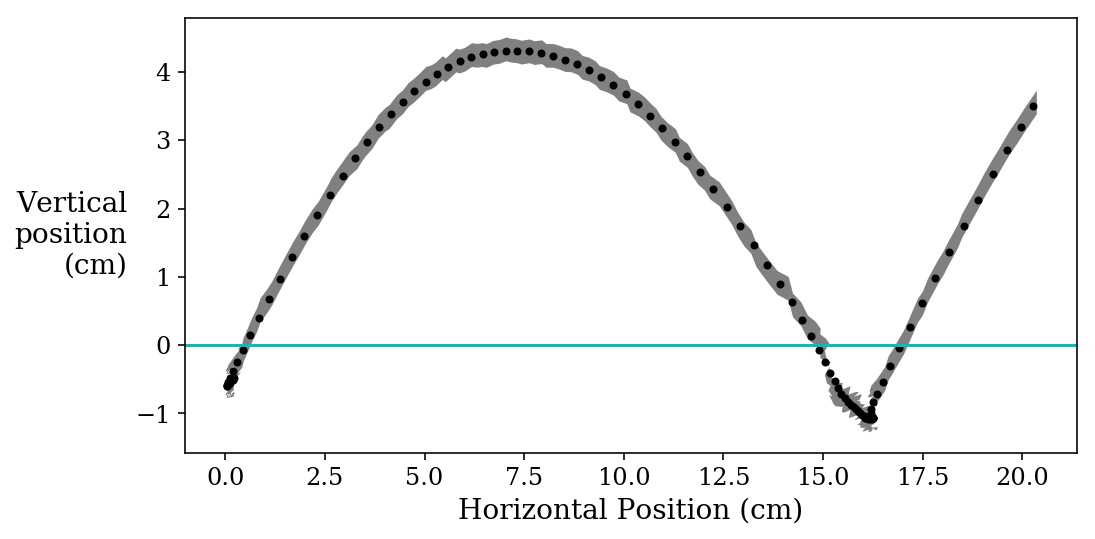

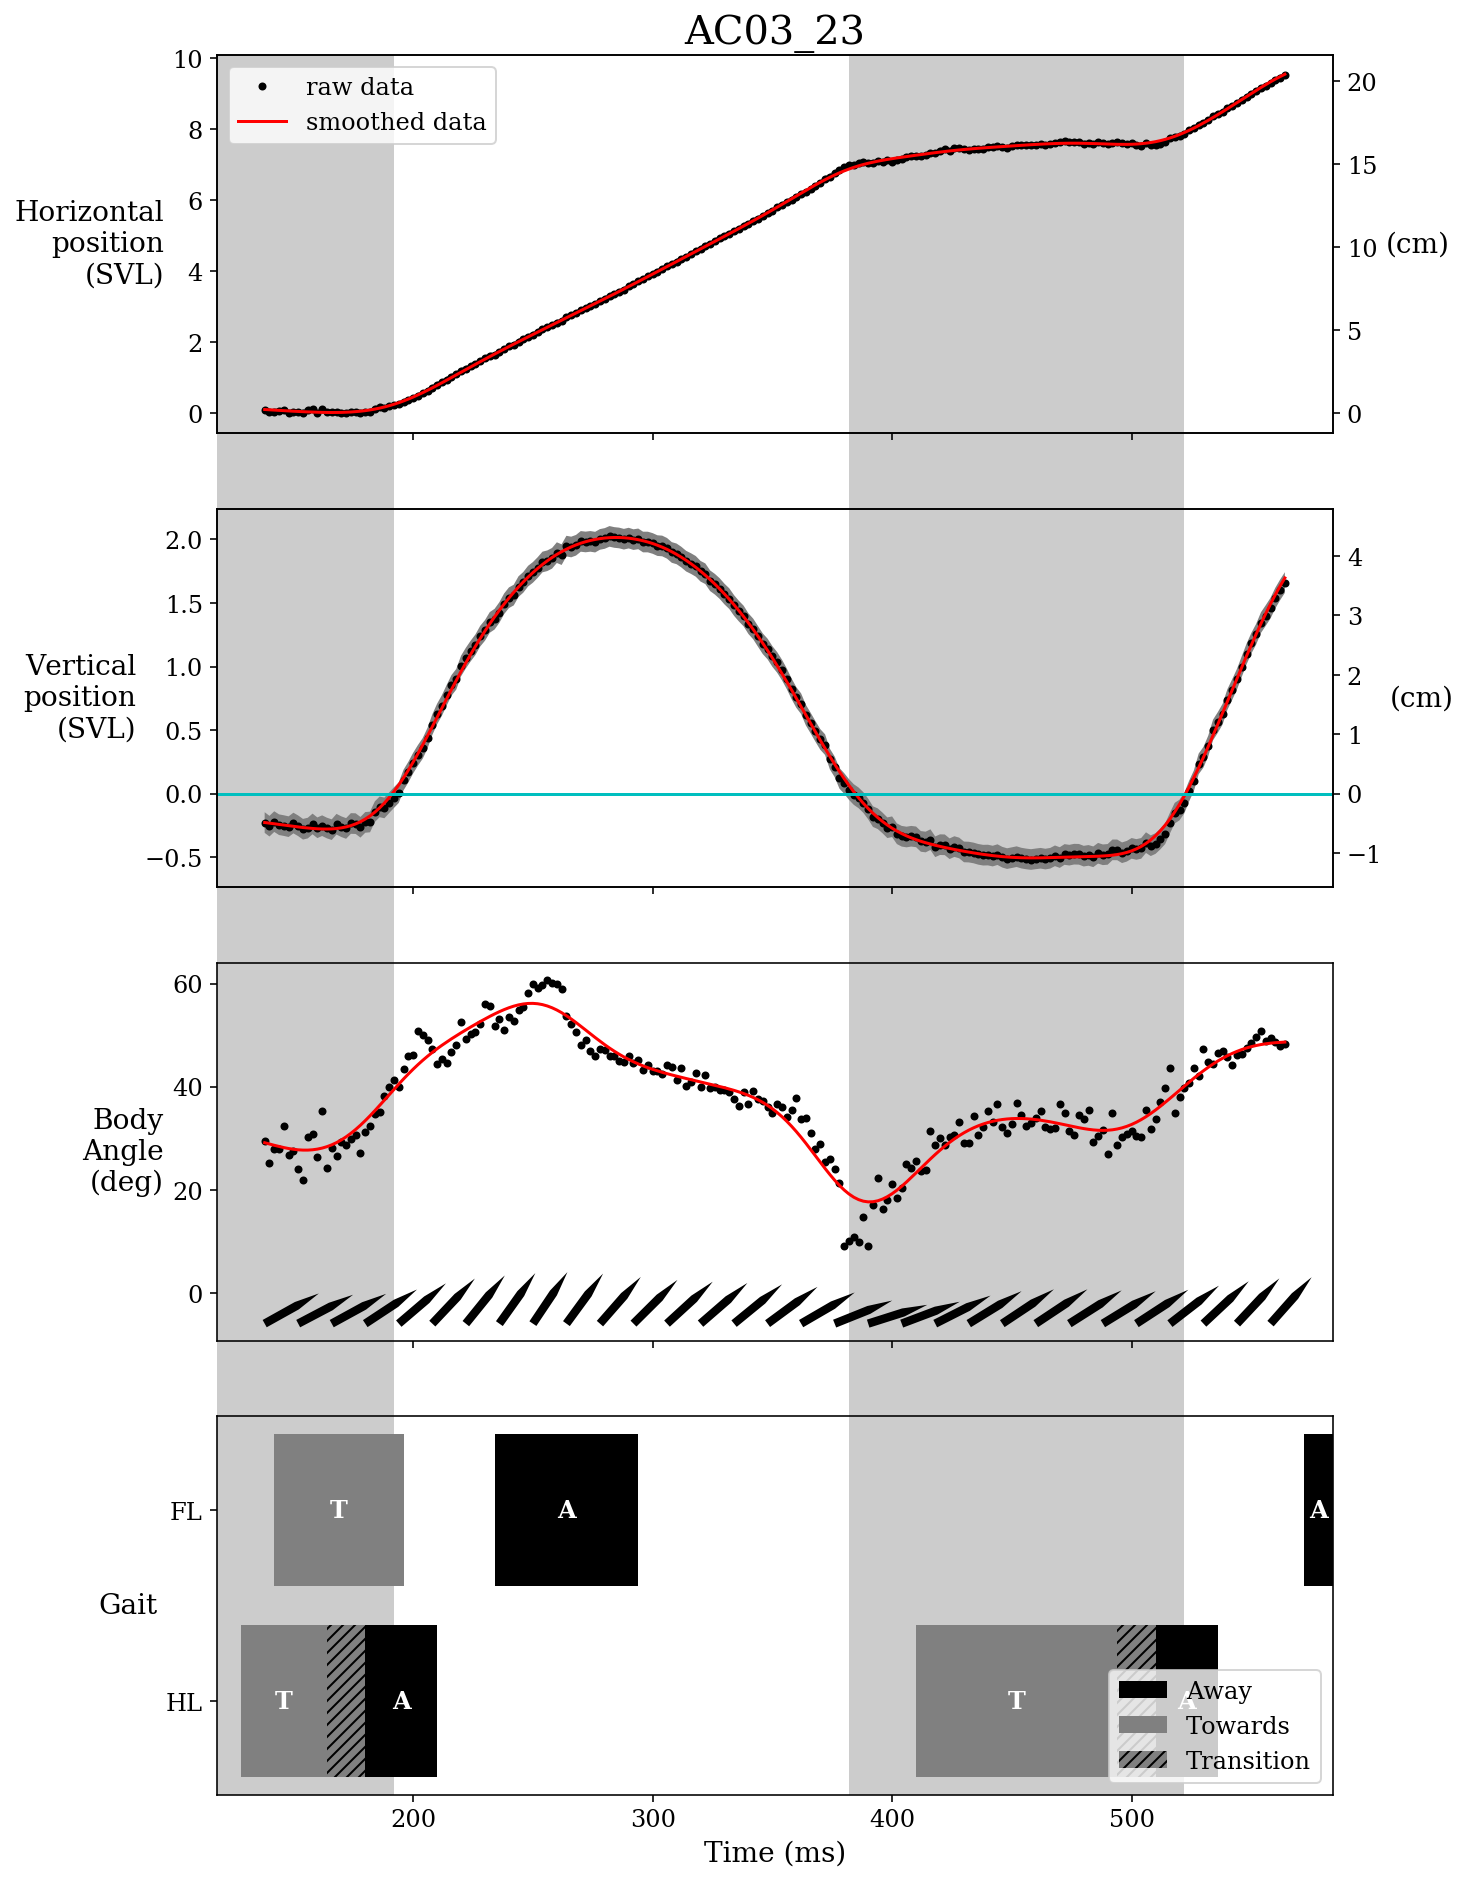

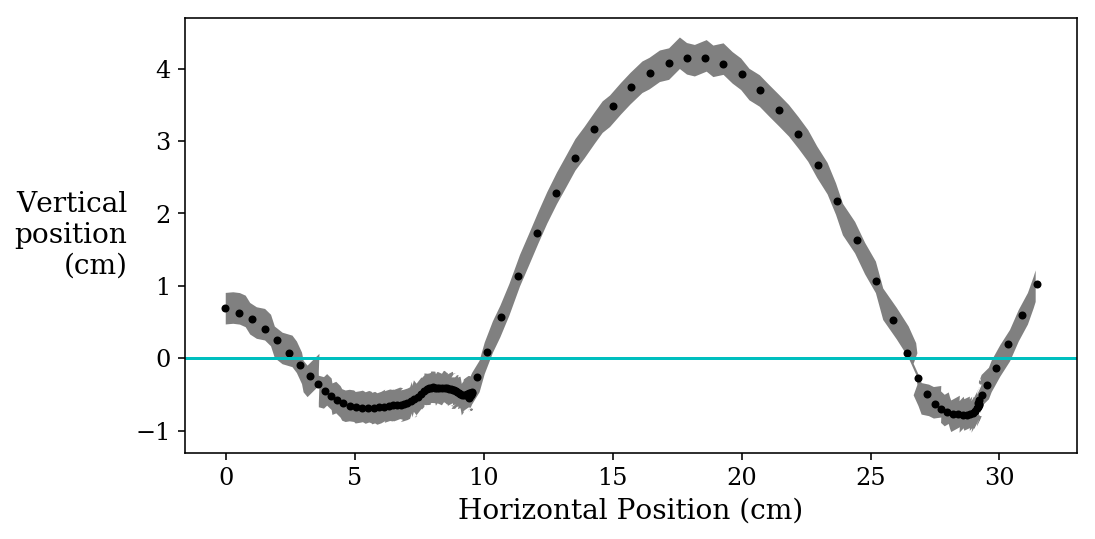

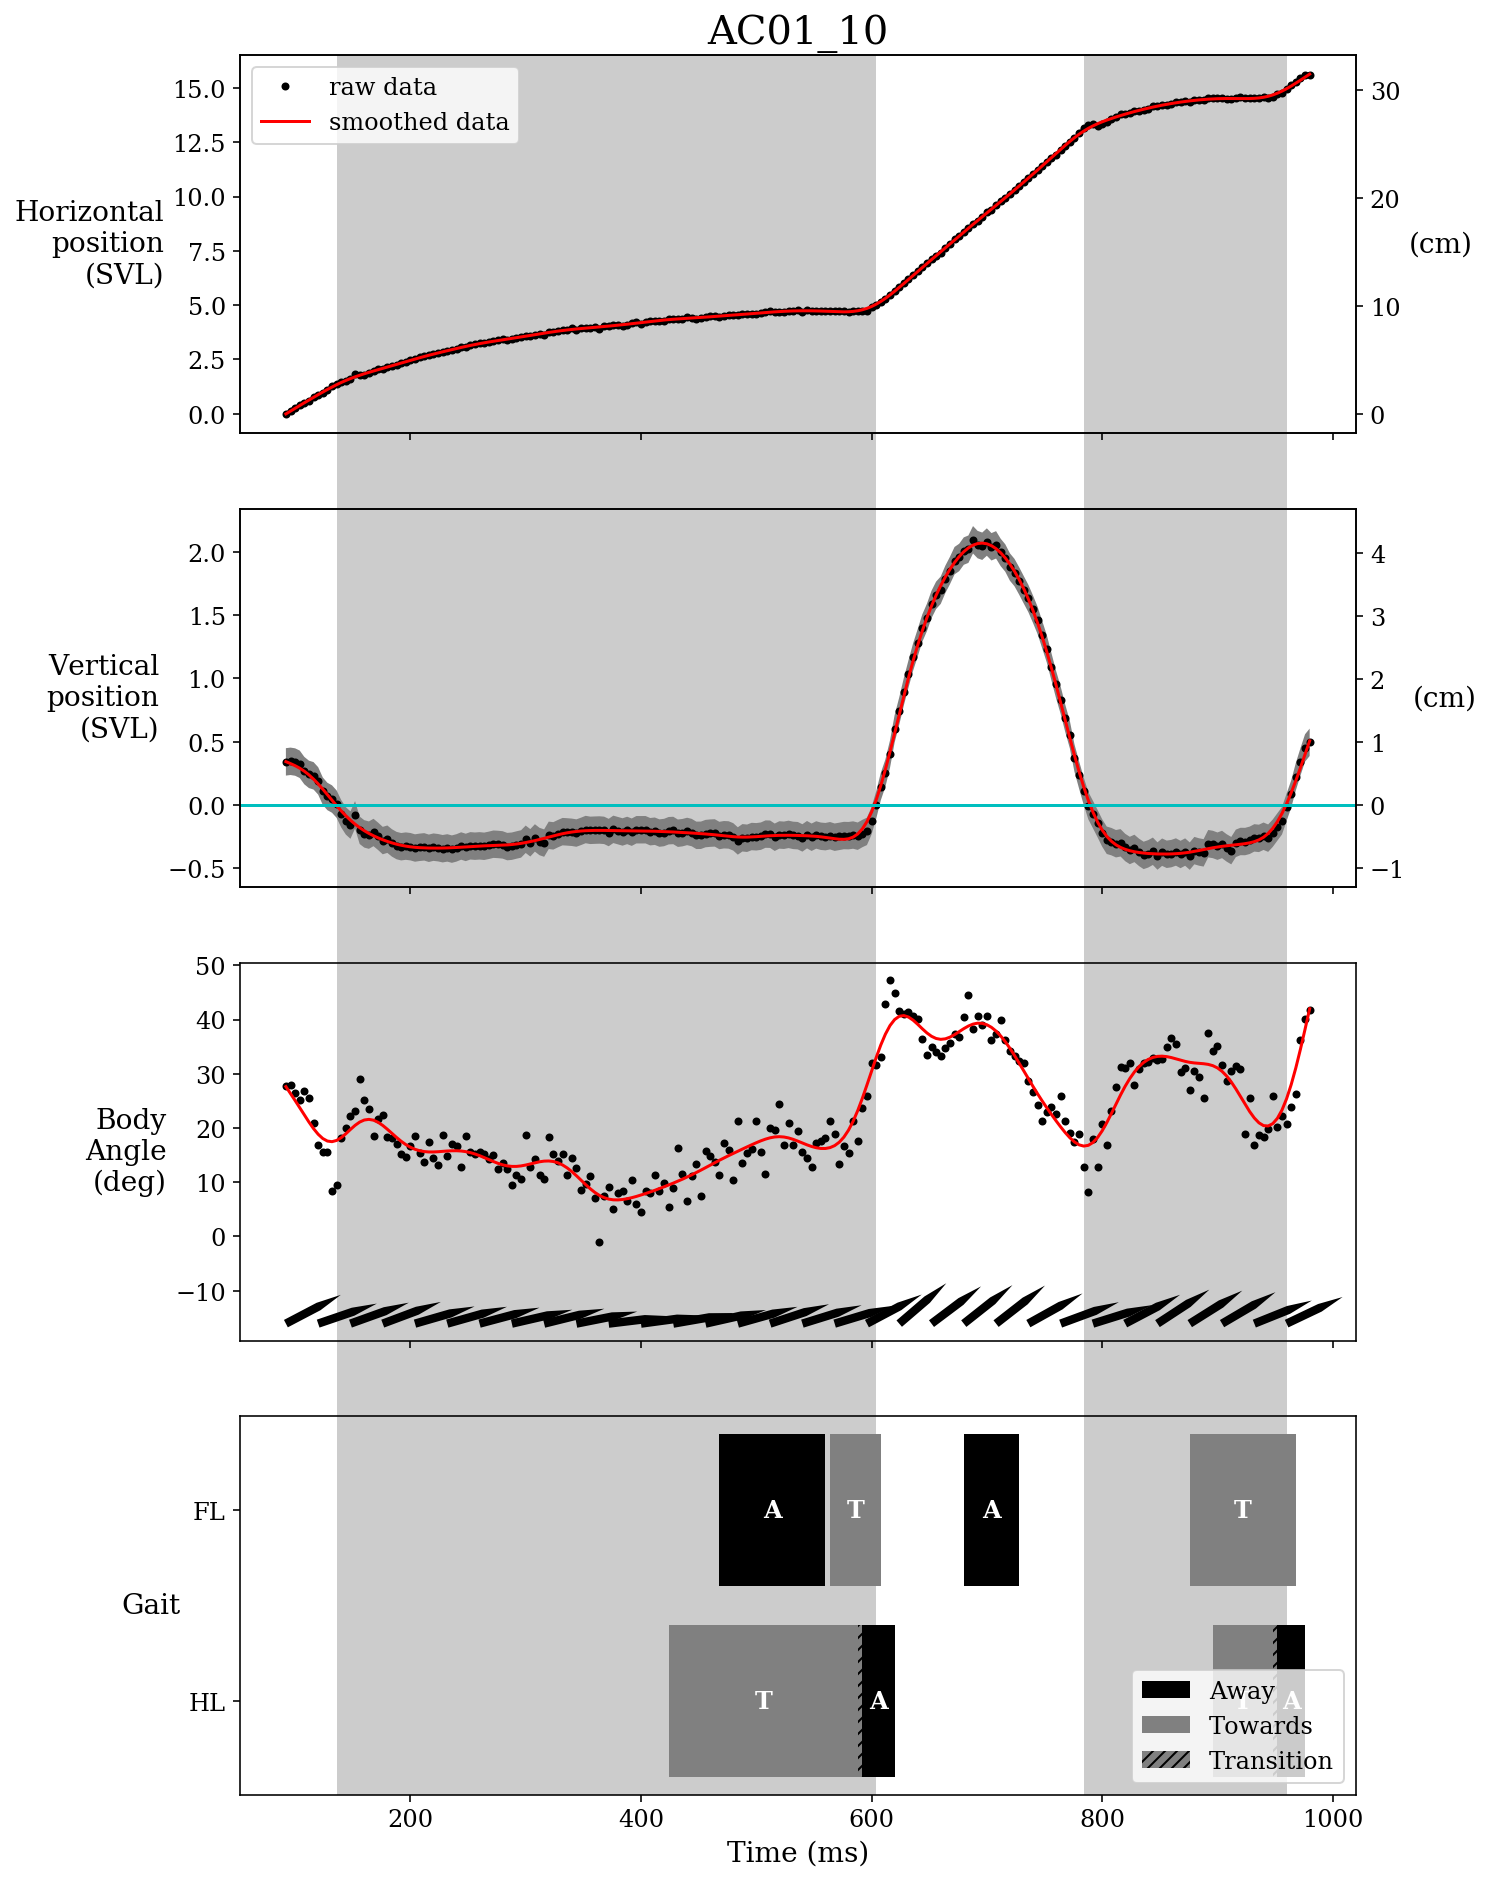

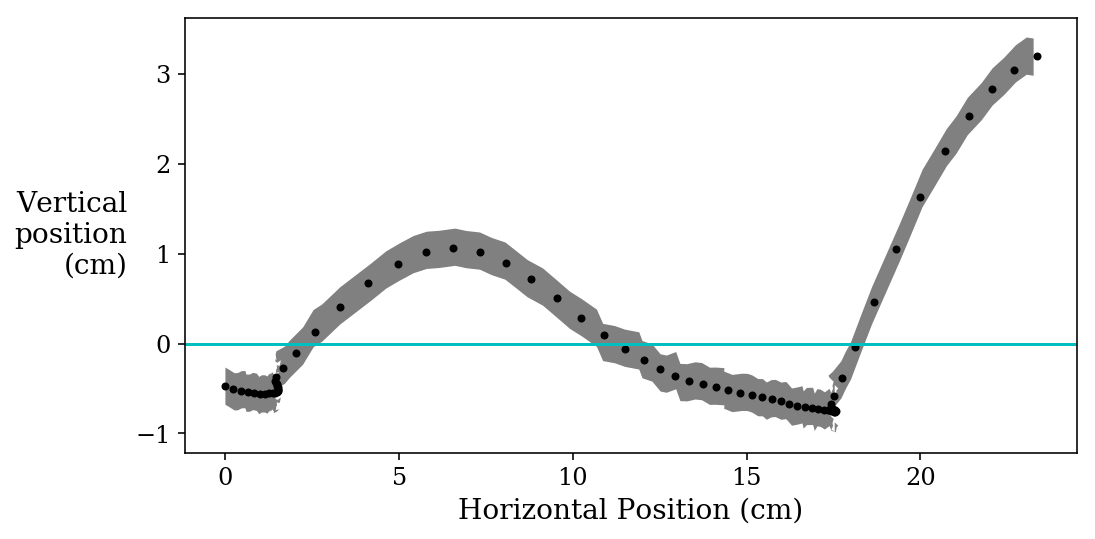

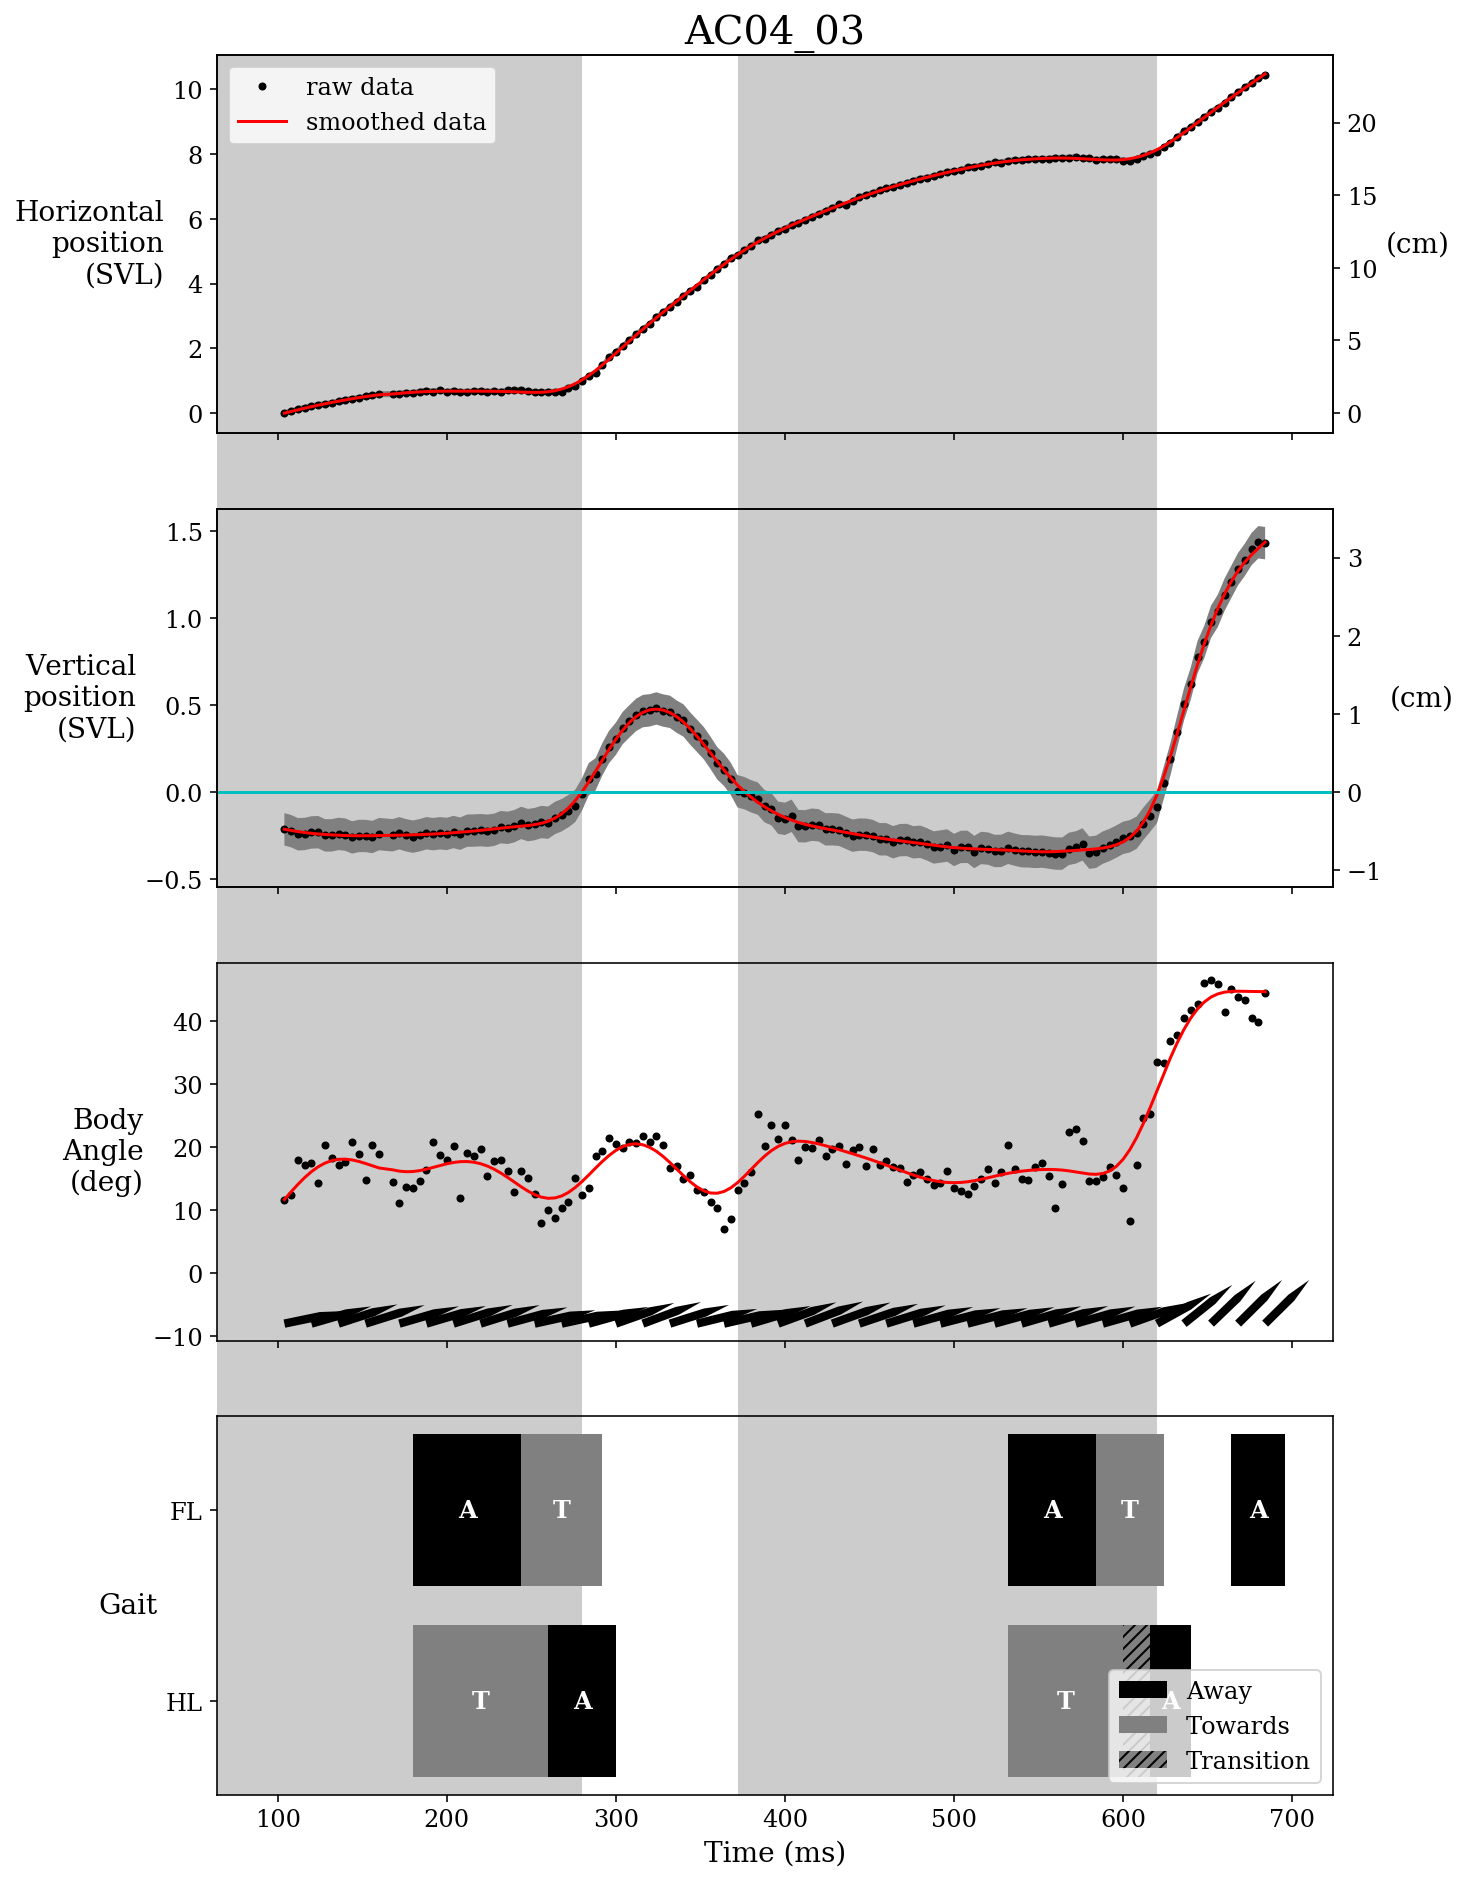

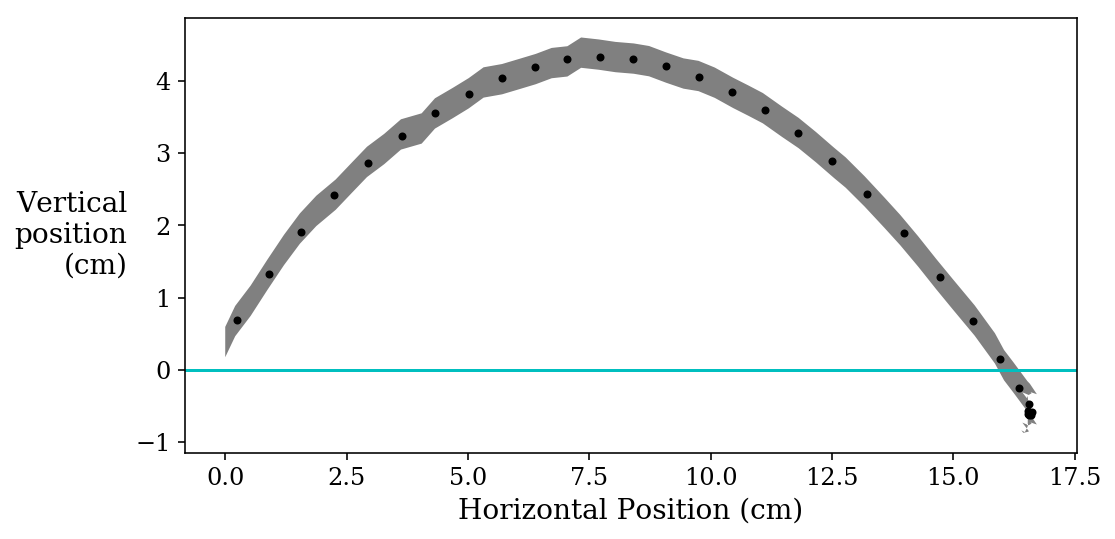

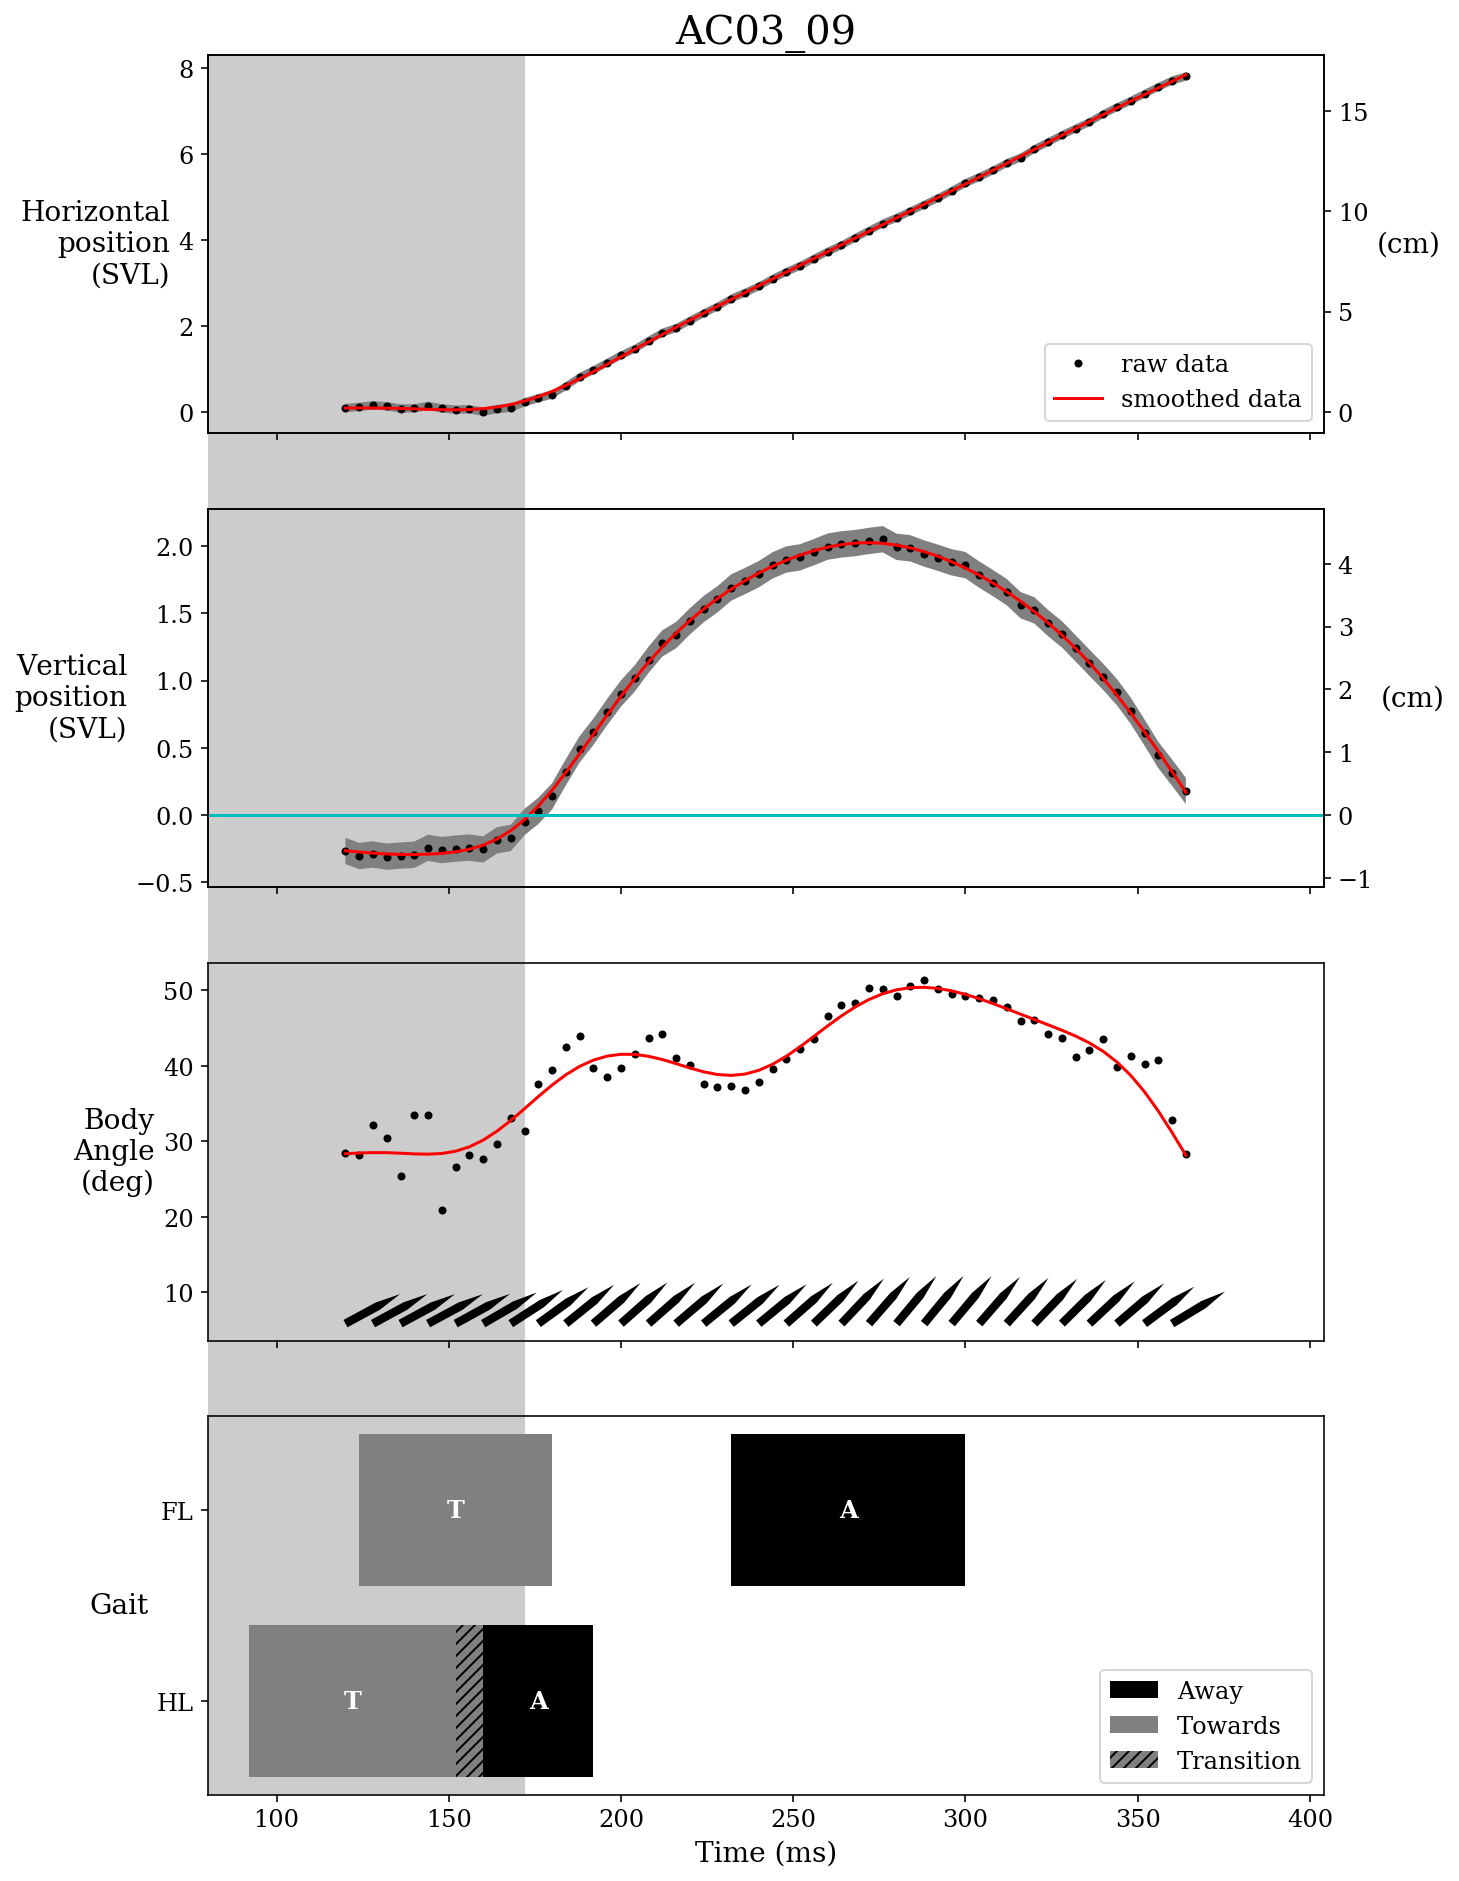

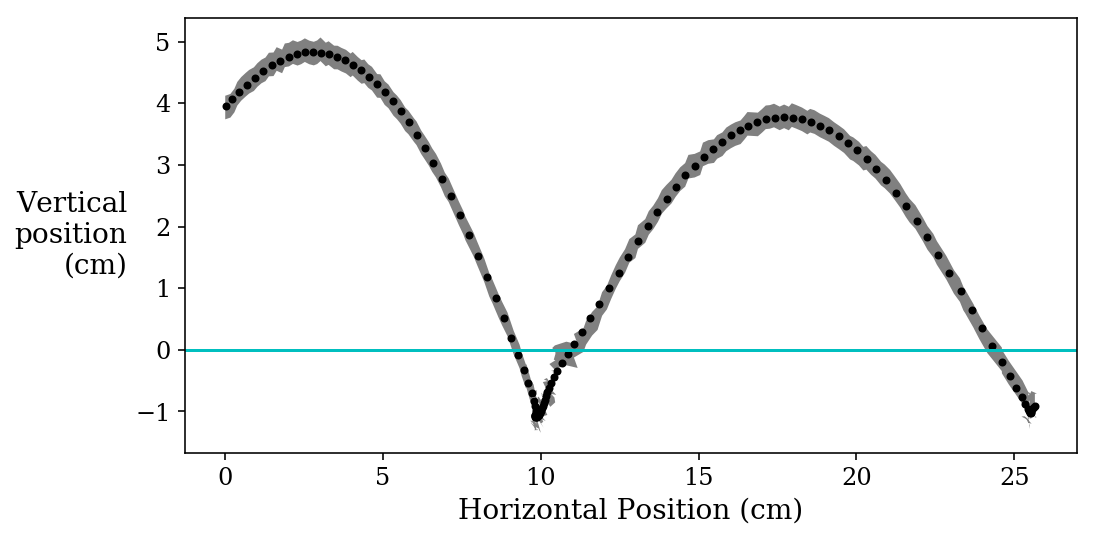

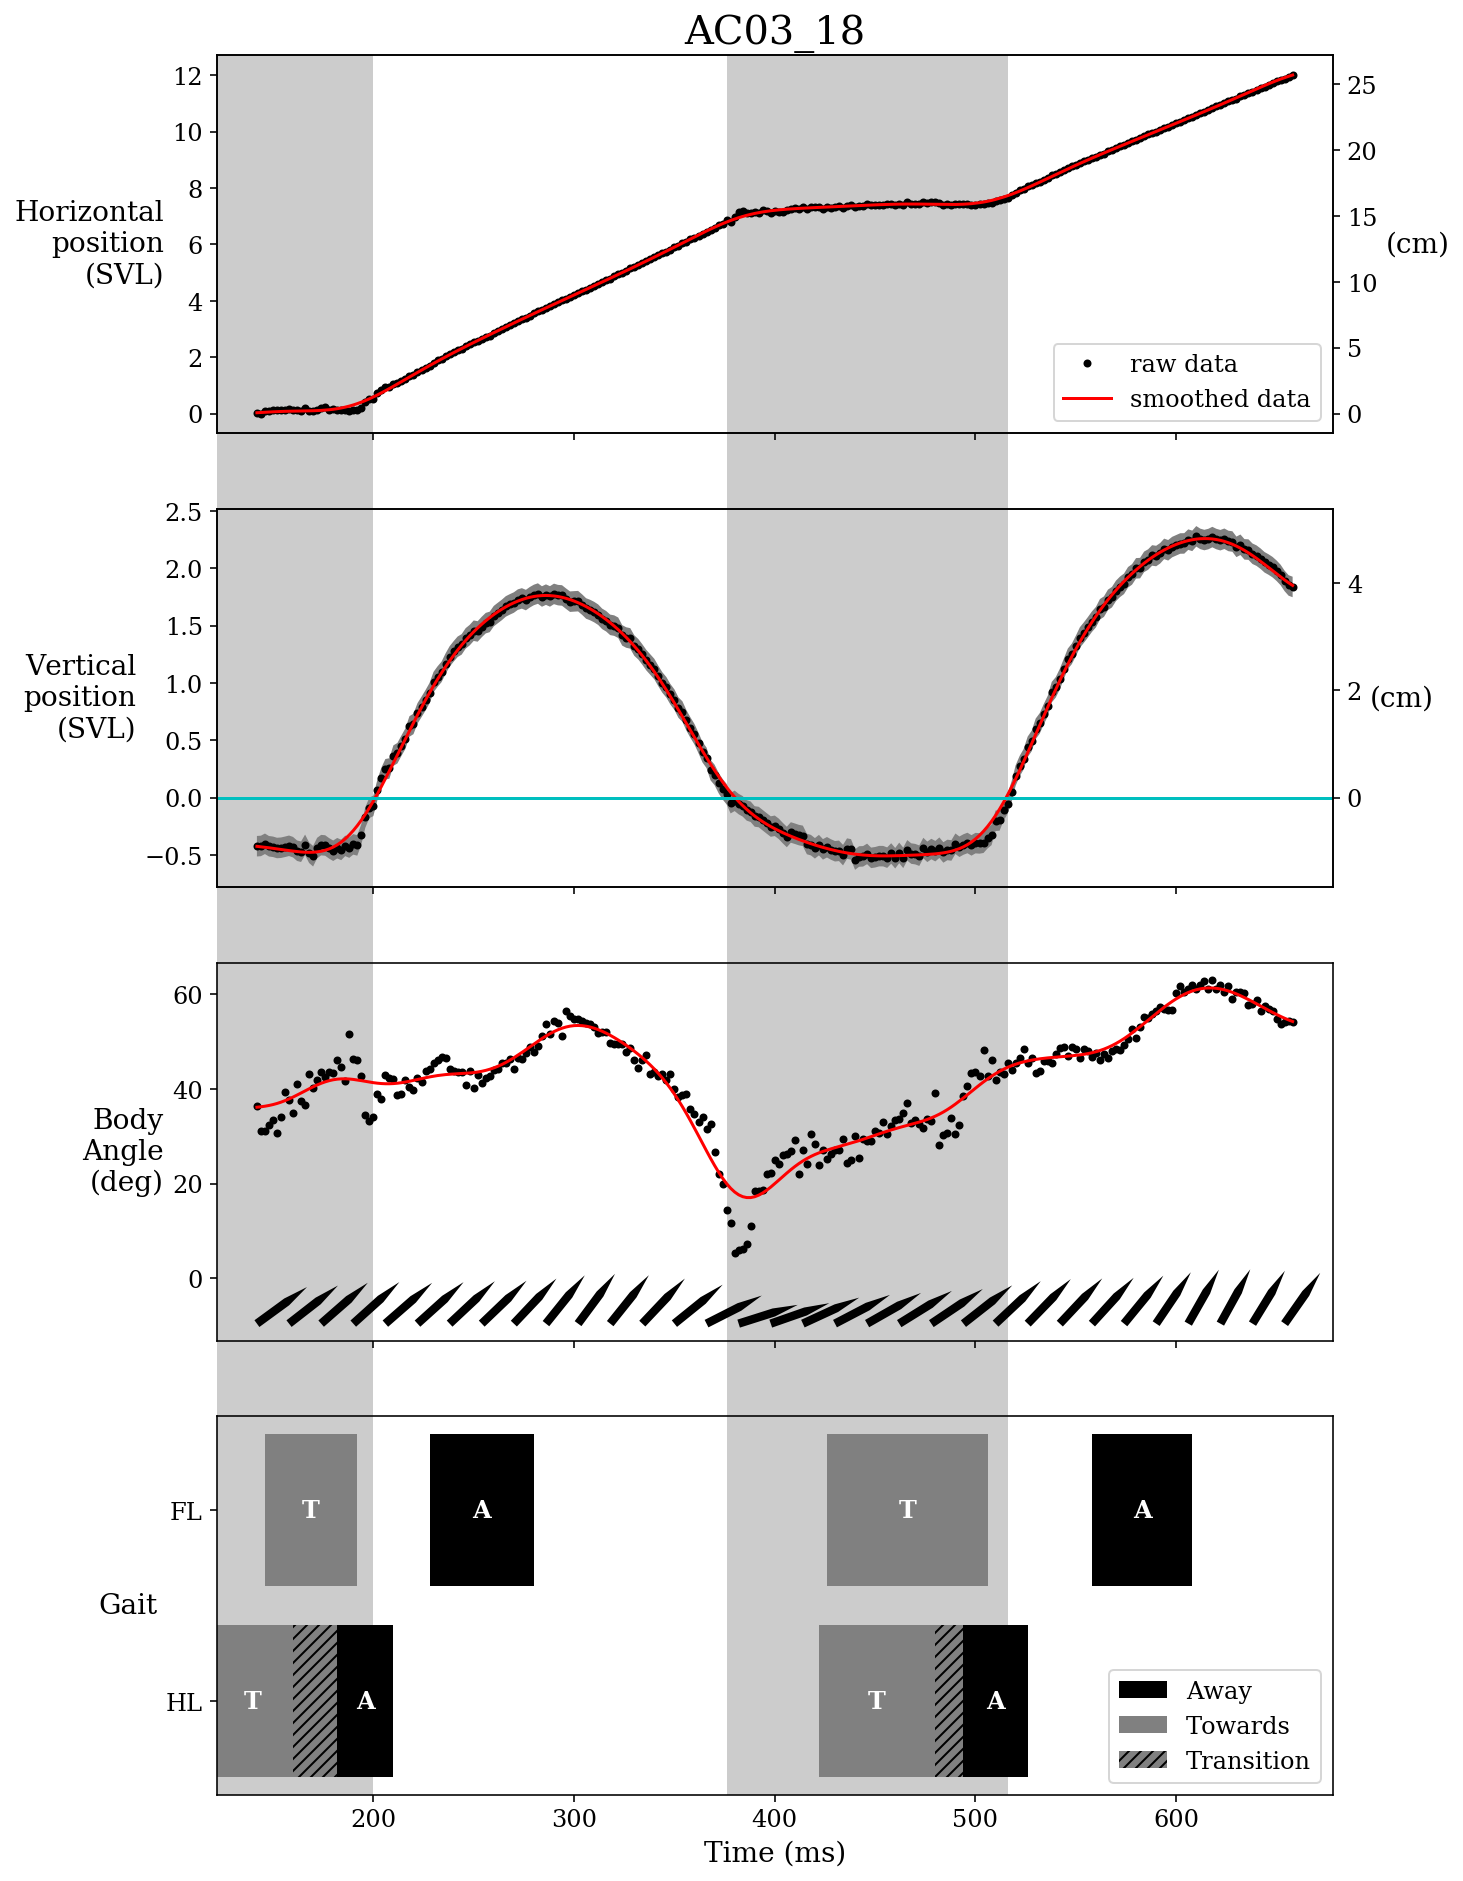

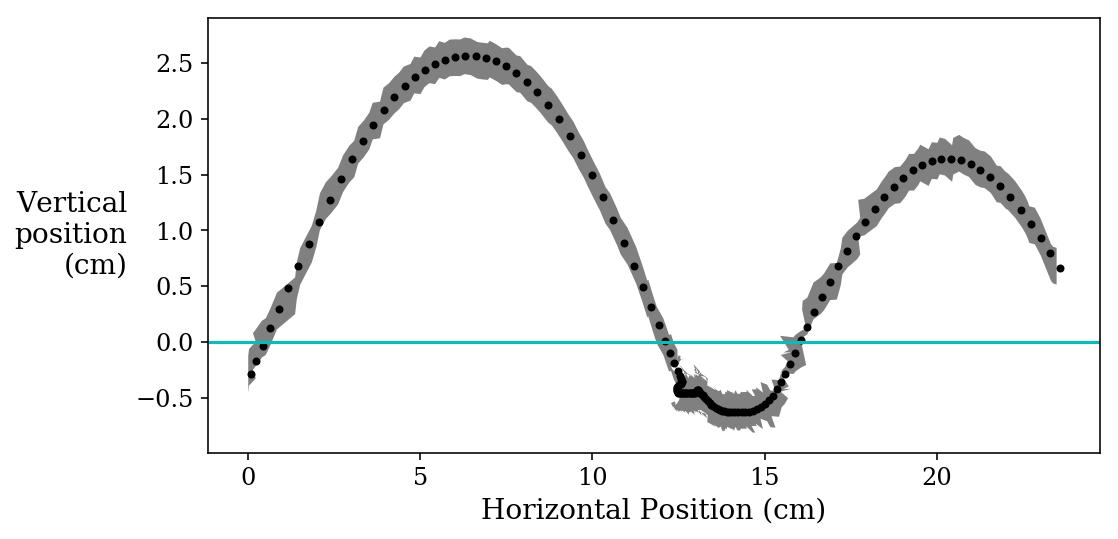

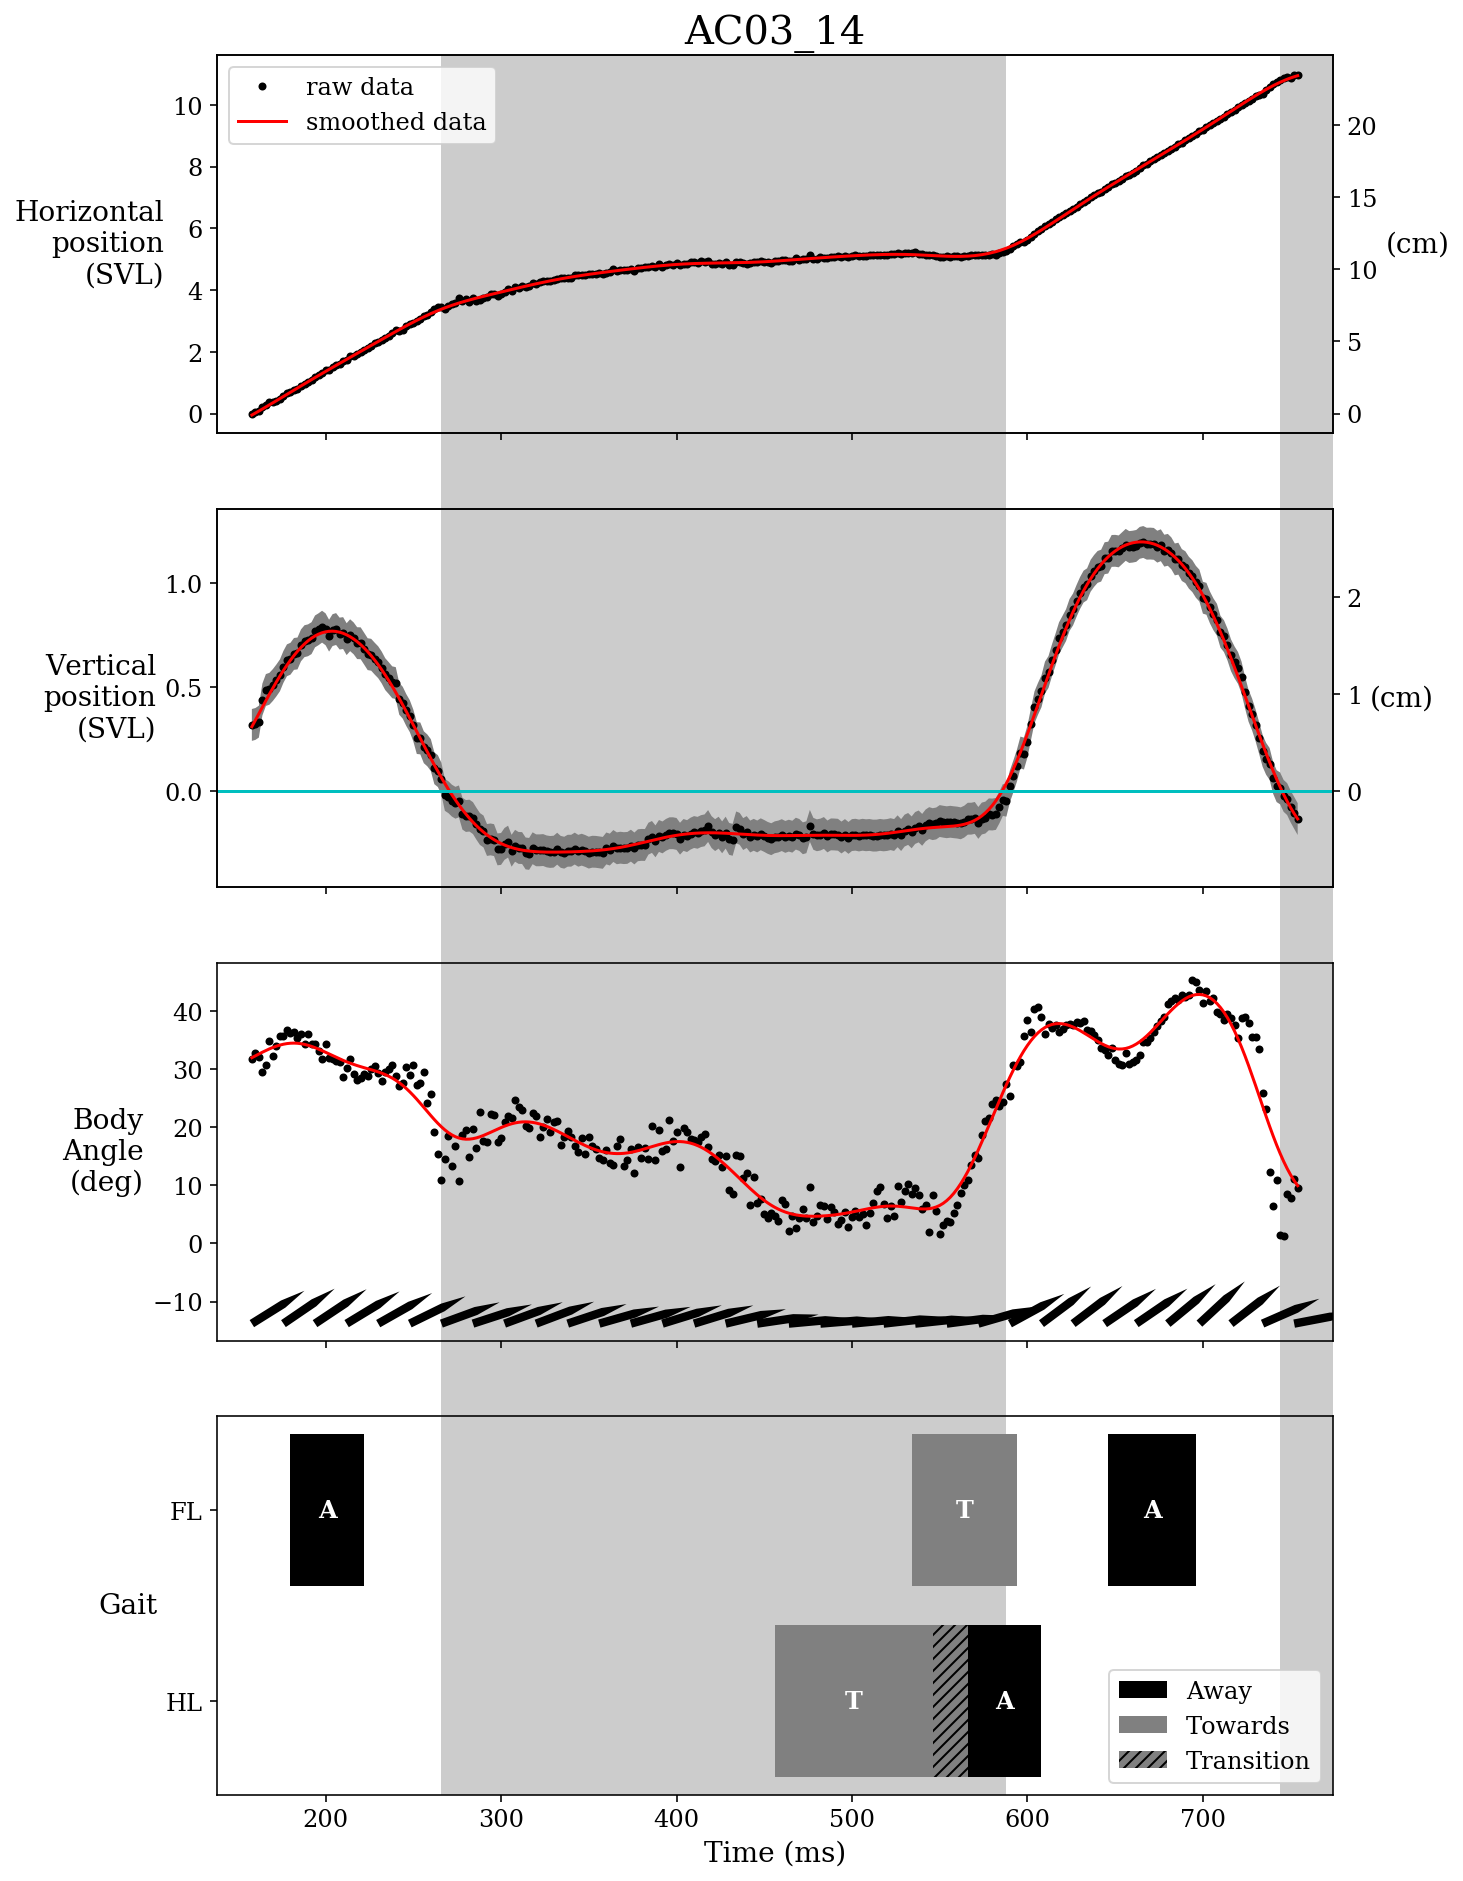

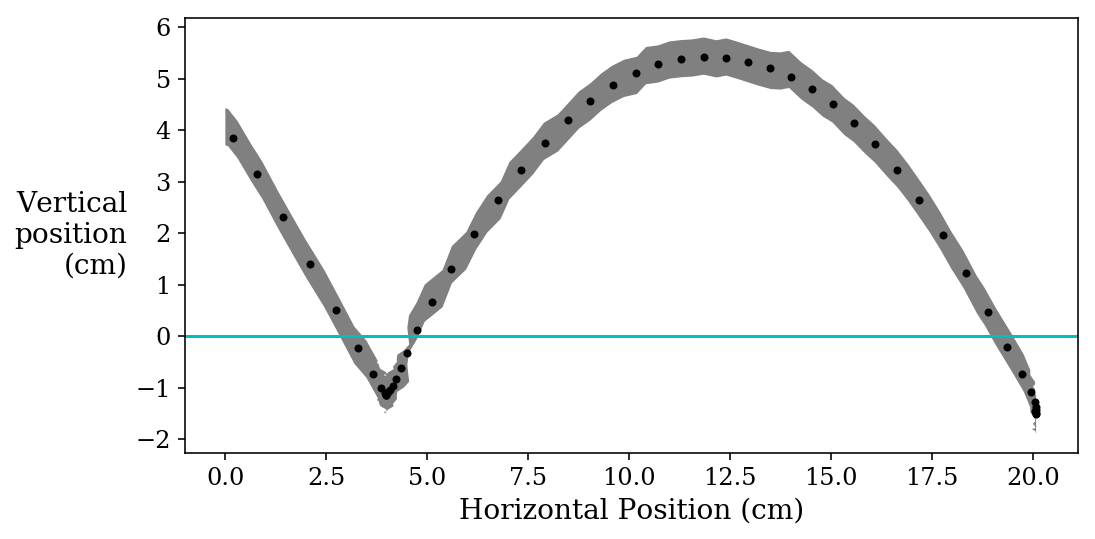

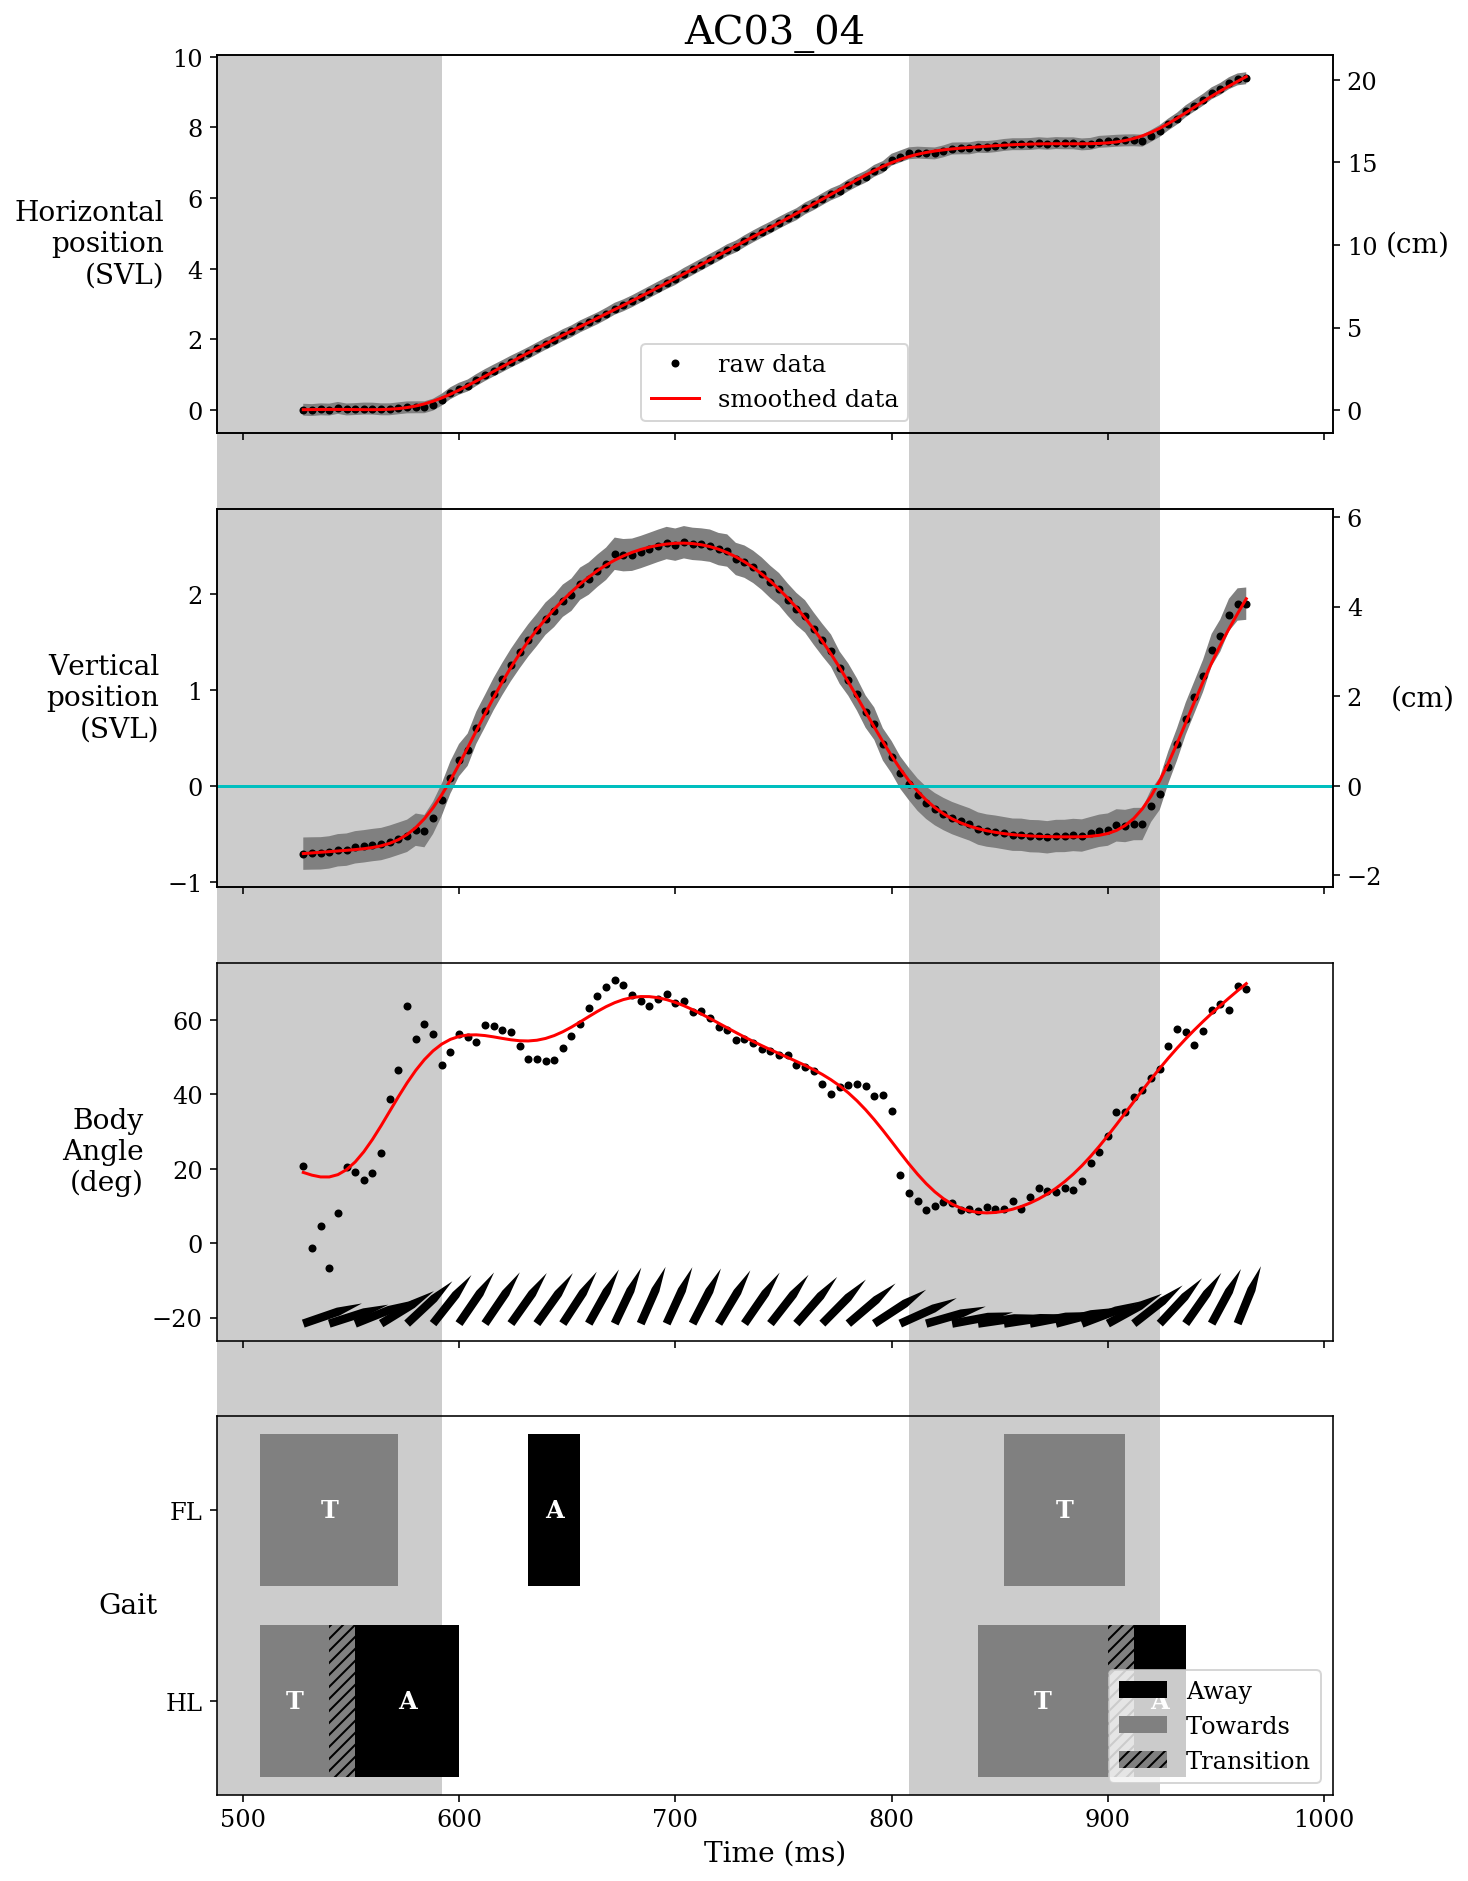

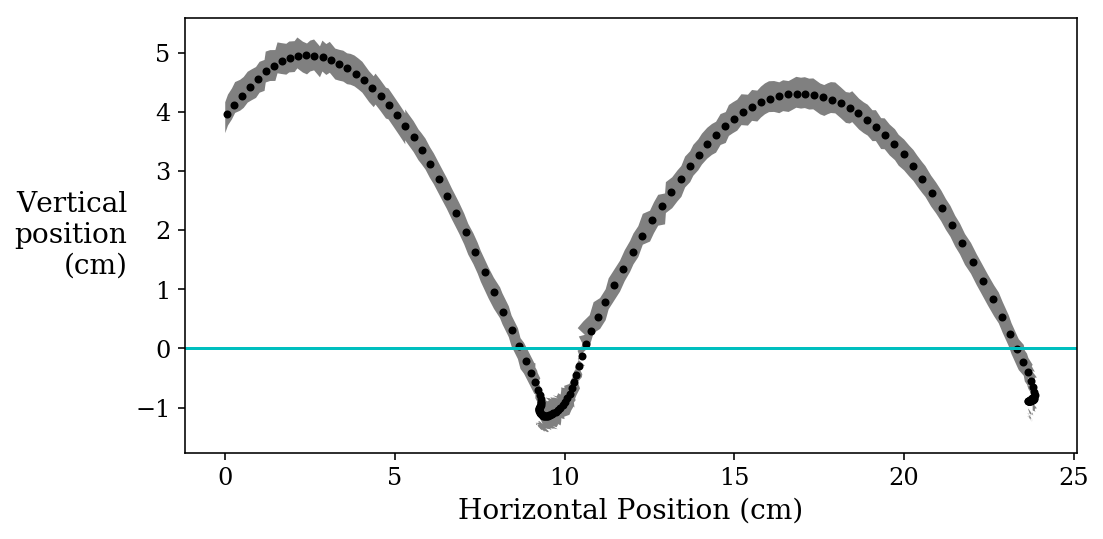

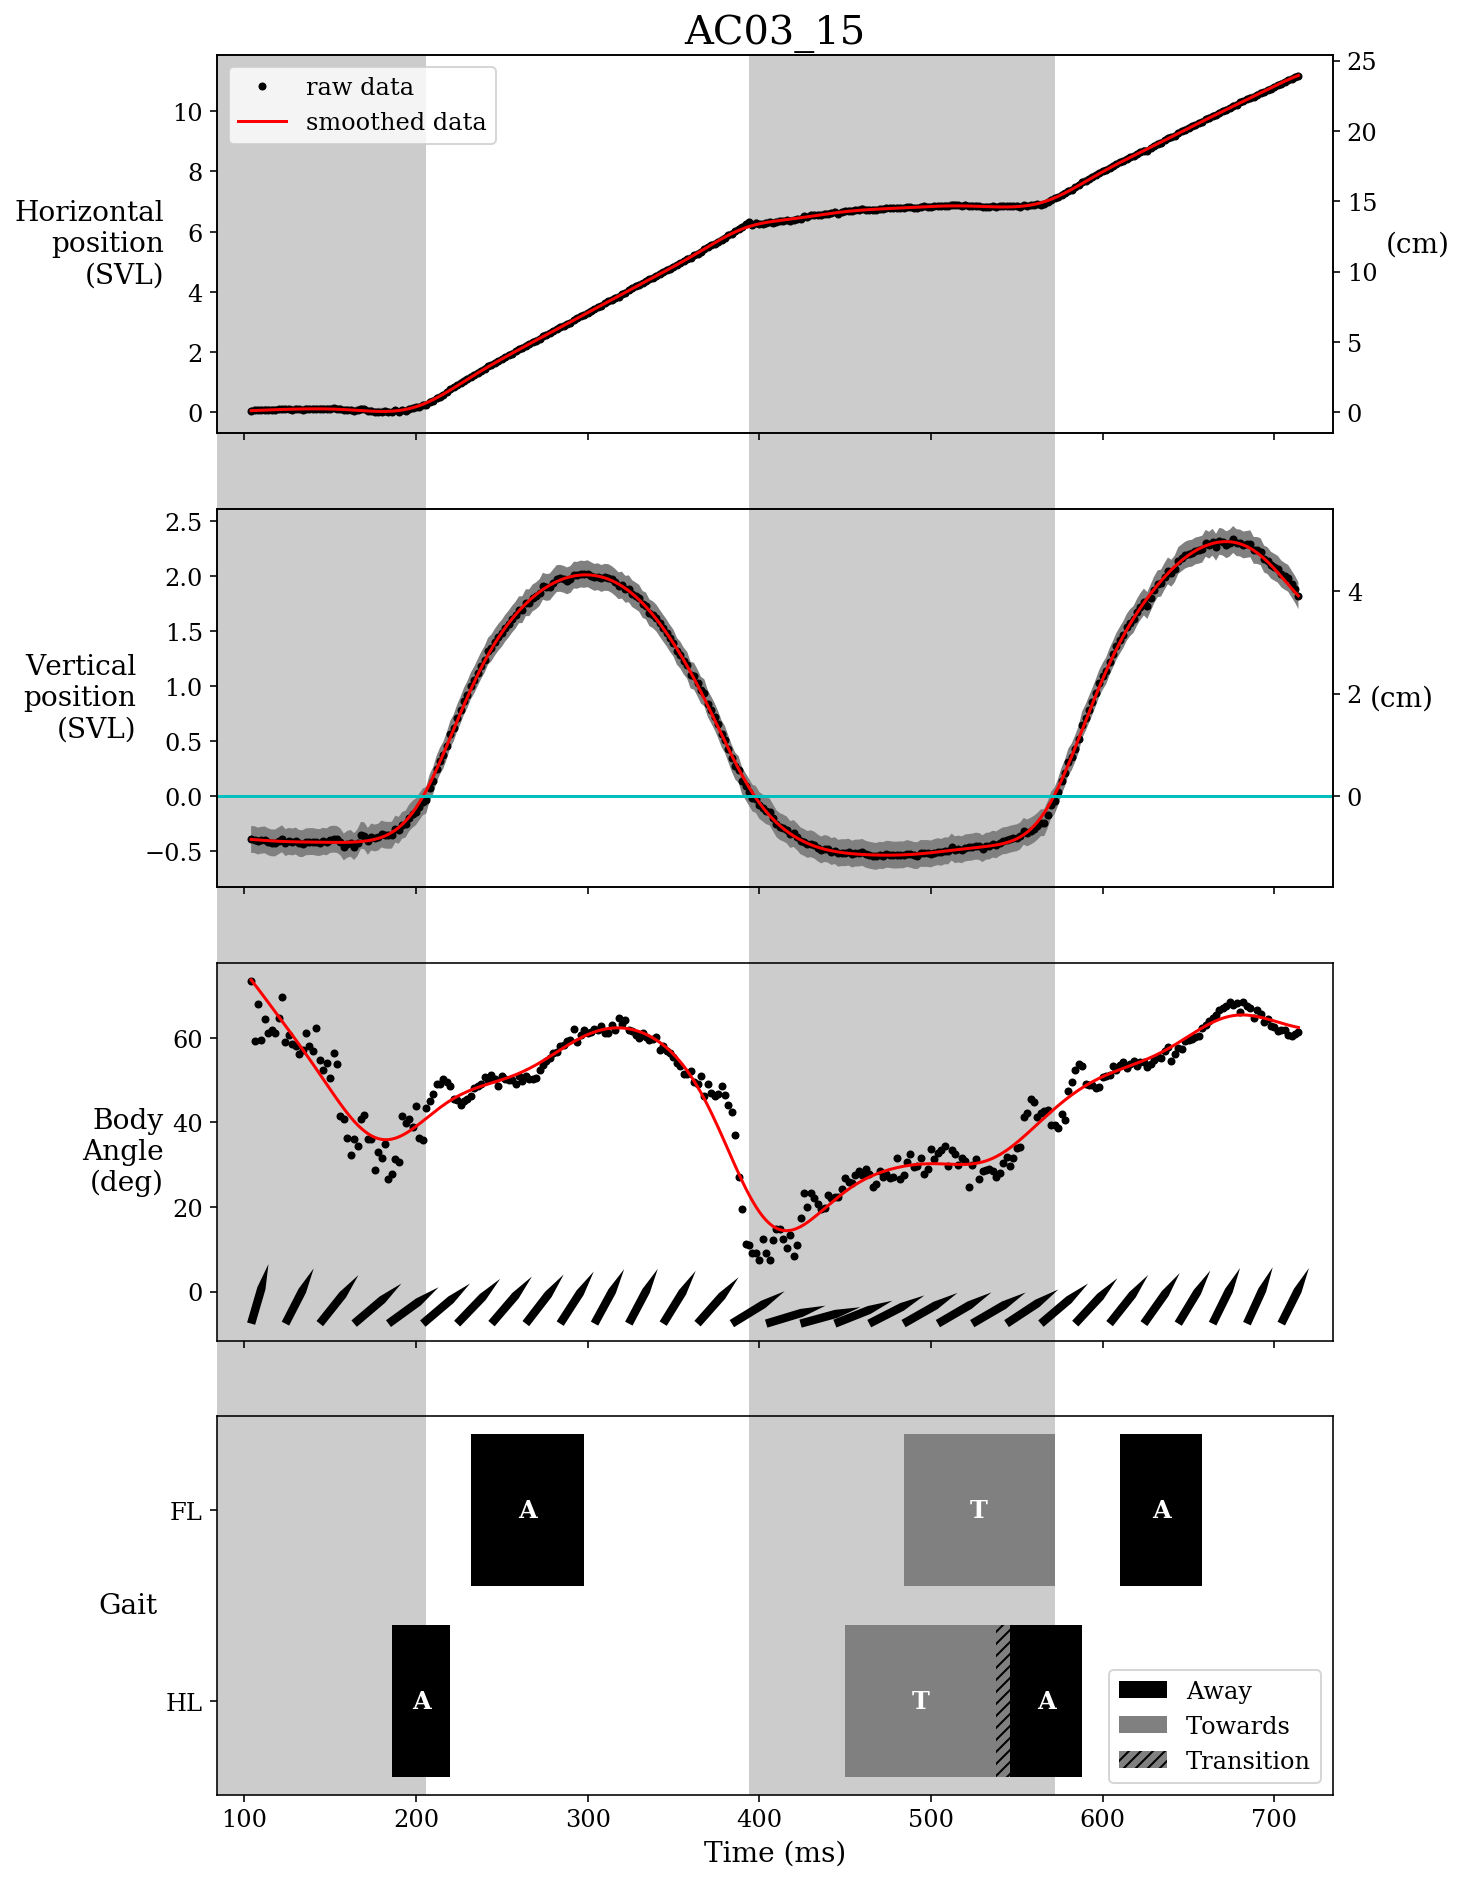

In [21]:
for key in data_allfiles.keys():
    graph_xy(key)
    graph_all(key, time = 'ms', rev=allfrog_rev[key])